# **Part A: Linear Classification Models**






# **A1. Data Preparation**

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Set seeds for reproducibility ---
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
import torch
from torchvision import datasets, transforms

# Define transform: converts images to tensors and normalizes to [0,1]
transform = transforms.ToTensor()

# Load dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_img = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Verify dataset sizes
print(f"Full train samples: {len(full_train_dataset)}, Test samples: {len(test_dataset_img)}")

# Take one example image and label
image, label = full_train_dataset[0]

print("Label:", label)
print("Image tensor shape:", image.shape)
print("Min pixel value:", torch.min(image).item())
print("Max pixel value:", torch.max(image).item())
print("Some pixel values:\n", image[0, :5, :5])


Full train samples: 60000, Test samples: 10000
Label: 5
Image tensor shape: torch.Size([1, 28, 28])
Min pixel value: 0.0
Max pixel value: 1.0
Some pixel values:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [8]:
image, label = full_train_dataset[0]
print("Single image shape:", image.shape)
print("Label:", label)

# Dataset sizes
print("Full train dataset size:", len(full_train_dataset))  # 60000
print("Test dataset size:", len(test_dataset_img))          # 10000


Single image shape: torch.Size([1, 28, 28])
Label: 5
Full train dataset size: 60000
Test dataset size: 10000


### Why We Normalize Pixel Values to 0–1

When working with images, each pixel’s intensity determines its brightness:

| Value Range | 0 (Black) | Middle Values (Gray) | Max Value (White) |
|-------------|-----------|----------------------|-------------------|
| **0–255**   | Black     | Shades of Gray       | White             |
| **0–1**     | Black     | Shades of Gray       | White             |

- **0 → Black** (no light)  
- **Middle values → Gray** (partial brightness)  
- **Max value → White** (full brightness)  

**Matplotlib behavior:**  
- Whether the range is **0–255** or **0–1**, `matplotlib` interprets values proportionally:
  - Mid-range values → **gray**  
  - Low values → **dark**  
  - High values → **bright**  

**Key Point:**  
- Normalizing to **0–1** does **not** change how the image looks.  
- It only makes model training **more stable and faster** by keeping input values in a small range.





In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


#80% train, 20% val and the test as it is

train_indices, val_indices, _, _ = train_test_split(
    range(len(full_train_dataset)),
    full_train_dataset.targets,           # labels for stratification
    stratify=full_train_dataset.targets,  # preserve class distribution
    test_size=0.2,
    random_state=42
)

#train_test_split is used with the stratify option.
# This ensures that both the training and validation sets have a similar distribution of each digit,
#which is a best practice to avoid skewed results



# Create subsets using the indices
train_dataset_img = Subset(full_train_dataset, train_indices)
val_dataset_img   = Subset(full_train_dataset, val_indices)

# Test dataset stays the same
test_dataset_img = datasets.MNIST(root='./data', train=False, download=True, transform=full_train_dataset.transform)


print(f"Train samples: {len(train_dataset_img)}")
print(f"Validation samples: {len(val_dataset_img)}")
print(f"Test samples: {len(test_dataset_img)}")


Train samples: 48000
Validation samples: 12000
Test samples: 10000


In [10]:

batch_size = 64  # mini-batch size for SGD stochastic


train_loader_img = DataLoader(train_dataset_img, batch_size=batch_size, shuffle=True) #to ensure reproducability
val_loader_img   = DataLoader(val_dataset_img, batch_size=batch_size, shuffle=False)
test_loader_img  = DataLoader(test_dataset_img, batch_size=batch_size, shuffle=False)


print(f"Number of batches (train): {len(train_loader_img)}, (val): {len(val_loader_img)}, (test): {len(test_loader_img)}")


Number of batches (train): 750, (val): 188, (test): 157


In [11]:
def get_flattened_tensors(dataset):
    """
    Converts images to flattened tensors of type float and normalizes [0,1].
    Handles both Subset and full Dataset objects.
    """
    if isinstance(dataset, Subset):
        # subset (train/val split)
        X = dataset.dataset.data[dataset.indices].view(-1, 28*28).float() / 255.0
        y = dataset.dataset.targets[dataset.indices]
    else:
        # full dataset (e.g., test set)
        X = dataset.data.view(-1, 28*28).float() / 255.0
        y = dataset.targets
    return X, y


# Apply function
X_train_flat_t, y_train_t = get_flattened_tensors(train_dataset_img)
X_val_flat_t, y_val_t     = get_flattened_tensors(val_dataset_img)
X_test_flat_t, y_test_t   = get_flattened_tensors(test_dataset_img)

# Verify shapes
print("Flattened shapes:")
print("Train:", X_train_flat_t.shape, y_train_t.shape)
print("Validation:", X_val_flat_t.shape, y_val_t.shape)
print("Test:", X_test_flat_t.shape, y_test_t.shape)


Flattened shapes:
Train: torch.Size([48000, 784]) torch.Size([48000])
Validation: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [12]:
print("Train data min/max:", X_train_flat_t.min().item(), X_train_flat_t.max().item())
print("Val data min/max:", X_val_flat_t.min().item(), X_val_flat_t.max().item())
print("Test data min/max:", X_test_flat_t.min().item(), X_test_flat_t.max().item())


Train data min/max: 0.0 1.0
Val data min/max: 0.0 1.0
Test data min/max: 0.0 1.0


In [13]:

train_dataset_flat = TensorDataset(X_train_flat_t, y_train_t)
val_dataset_flat   = TensorDataset(X_val_flat_t, y_val_t)
test_dataset_flat  = TensorDataset(X_test_flat_t, y_test_t)


train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat   = DataLoader(val_dataset_flat, batch_size=batch_size, shuffle=False)
test_loader_flat  = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)


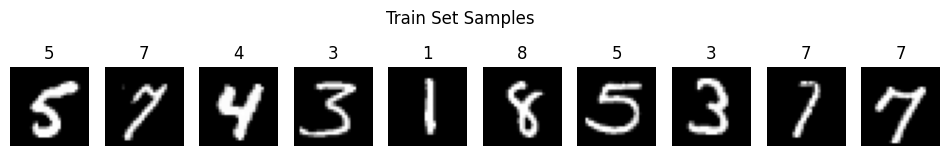

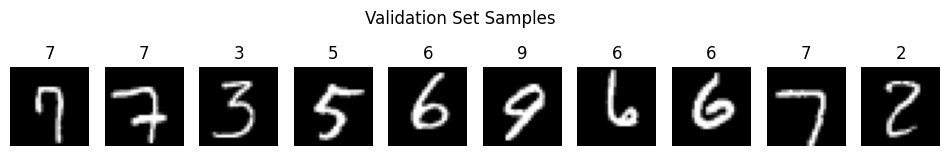

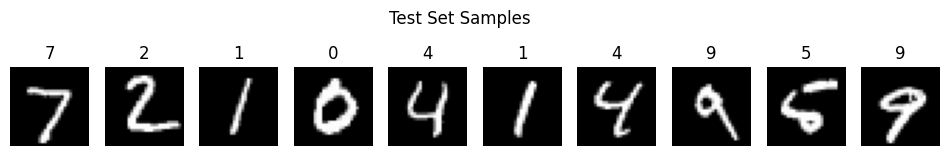

In [14]:
def plot_images(X, y, title, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        if X[i].ndim == 1:  # flattened
            img = X[i].view(28,28)
        else:                # image format
            img = X[i].squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(int(y[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot first batch of images
X_train_batch, y_train_batch = next(iter(train_loader_img))
X_val_batch, y_val_batch     = next(iter(val_loader_img))
X_test_batch, y_test_batch   = next(iter(test_loader_img))

plot_images(X_train_batch, y_train_batch, "Train Set Samples")
plot_images(X_val_batch, y_val_batch, "Validation Set Samples")
plot_images(X_test_batch, y_test_batch, "Test Set Samples")


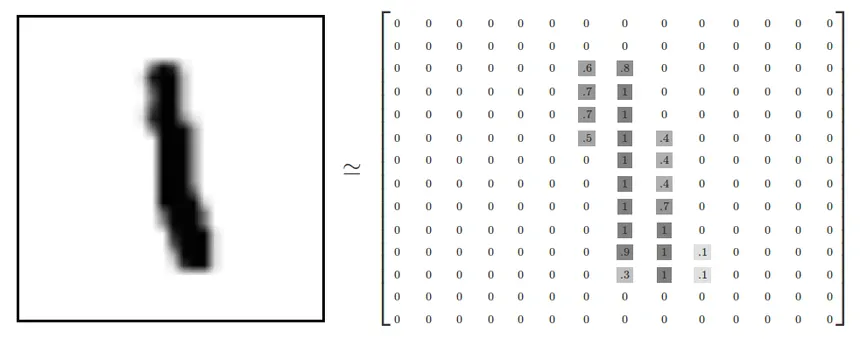


In [15]:
# X = X.astype(np.float32) / 255.0   #to give decimal number "middle numbers"
# # why not float64 ? ---> pyTorch , TensorFlow only deals with float32
# # Convert to float32 for ML frameworks (PyTorch/TensorFlow) because:
# # - float32 is the standard type for training
# # - avoids unnecessary memory use compared to float64



## **A2. Binary Logistic Regression Implementation (from scratch in PyTorch)**


####Step 1 – Filter dataset to distinguish between two digits (e.g., 0 vs 1).


In [16]:
def filter_binary(X, y, digit1, digit2):

    mask = (y == digit1) | (y == digit2)
    # A Boolean mask where True means this sample is either digit1 or digit2.

    # Apply the mask to features and labels.
    X_bin = X[mask]  # Selects only those rows from X where mask is True.
    y_bin = y[mask]  # Selects only the labels corresponding to the chosen digits.

    # Optional:
    # The labels might not be literally 0 and 1 in every case (e.g., 0–9).
    # Convert labels to 0/1
    y_bin = (y_bin == digit2).long()  # .long(): Converts True -> 1 and False -> 0 as integers (torch long = int64).
    # Without this, you’d still be training on digits 2, 3, 4, etc

    return X_bin, y_bin

# Select digits 0 and 1 from train, val, test sets
X_train_bin, y_train_bin = filter_binary(X_train_flat_t, y_train_t, 0, 1)
X_val_bin,   y_val_bin   = filter_binary(X_val_flat_t, y_val_t, 0, 1)
X_test_bin,  y_test_bin  = filter_binary(X_test_flat_t, y_test_t, 0, 1)


# Create TensorDatasets for PyTorch
train_dataset_bin = TensorDataset(X_train_bin, y_train_bin)
val_dataset_bin   = TensorDataset(X_val_bin, y_val_bin)
test_dataset_bin  = TensorDataset(X_test_bin, y_test_bin)

# Create DataLoaders
train_loader_bin = DataLoader(train_dataset_bin, batch_size=batch_size, shuffle=True)
val_loader_bin   = DataLoader(val_dataset_bin, batch_size=batch_size, shuffle=False)
test_loader_bin  = DataLoader(test_dataset_bin, batch_size=batch_size, shuffle=False)

print(f"Binary train batches: {len(train_loader_bin)}, val batches: {len(val_loader_bin)}, test batches: {len(test_loader_bin)}")


Binary train batches: 159, val batches: 40, test batches: 34


In [17]:
# Check sizes
print("Train binary:", X_train_bin.shape, y_train_bin.shape)
print("Validation binary:", X_val_bin.shape, y_val_bin.shape)
print("Test binary:", X_test_bin.shape, y_test_bin.shape)


Train binary: torch.Size([10132, 784]) torch.Size([10132])
Validation binary: torch.Size([2533, 784]) torch.Size([2533])
Test binary: torch.Size([2115, 784]) torch.Size([2115])


####Step 2 – Create DataLoaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64  # common practical default, MINI BATCH, SGD
# can be any positive power-of-2 integer but 64 balances (Memory usage, Hardware efficiency, Training speed, gradient stability).

# Convert the filtered binary datasets into TensorDataset and wrap with DataLoader
train_loader_bin = DataLoader(
    TensorDataset(X_train_bin, y_train_bin),
    batch_size=batch_size,
    shuffle=True  # shuffle=True for training ensures data order is randomized each epoch
)

val_loader_bin = DataLoader(
    TensorDataset(X_val_bin, y_val_bin),
    batch_size=batch_size,
    shuffle=False  # validation loader does not need shuffling
)

test_loader_bin = DataLoader(
    TensorDataset(X_test_bin, y_test_bin),
    batch_size=batch_size,
    shuffle=False  # test loader does not need shuffling
)

# Verification: print number of batches
print("Number of batches:")
print(f"Train: {len(train_loader_bin)}, Val: {len(val_loader_bin)}, Test: {len(test_loader_bin)}")


Number of batches:
Train: 159, Val: 40, Test: 34


####Step 3 – Initialize weights and bias parameters manually (no nn.Module)

In [19]:
# # Input size = 784 features, output = 1 (probability of class 1)
# # You flattened each image to a vector of length 28×28.

# w = torch.zeros((784, 1), dtype=torch.float32, requires_grad=True)
# # weight matrix of size (784, 1)_one weight per pixel, producing one output value.
# # To be multiplied with x (1,784)
# # Your inputs are float32, so parameters should match.
# # enabling "requires_grad=True" for autograd.


# # z=  X*W +B
# # (1,784) * (784,1) + (1,1)



# b = torch.zeros(1, dtype=torch.float32, requires_grad=True)
# # bias of size (1,)_a single scalar added to every sample’s score no matter what the pixels are.

# #  w,b are zero-initialized by using torch.zeros.

# # autograd for making pytorch takes notes about losses to update weigths w.grad and b.grad

####Step 4 – Define the logistic regression forward function

In [20]:
def logistic_regression(X):
    z = X @ w + b      # Linear transformation
   # logit is just the raw score before applying the sigmoid function.

    return torch.sigmoid(z)  # ensures outputs are in range (0, 1) for probabilities.


####Step 5 – Define Binary Cross-Entropy Loss

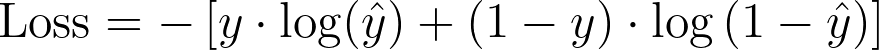

In [21]:
# manually implement BCE loss.

def binary_cross_entropy(y_pred, y_true):
    # y_true: shape (batch, 1), y_pred: shape (batch, 1).

    eps = 1e-7   # Small epsilon to avoid log(0), which is undefined.
     # Small constant to avoid log(0), which is undefined and would cause NaN values.

    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    # avoid undefined values in log so they never hit exactly 0 or 1.
     # Clamp predictions to be within [eps, 1 - eps]
    # This ensures no value is exactly 0 or 1, preventing infinite loss values.

    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss.mean()  # Average over all samples in the batch.



Looks like: [1, 2, 3, 4, ..., 10] 1-D array
Shape = (10,) (only length, no extra axis)

Shape = (10,1) (10 rows × 1 column) column vector
looks like:
[[1],
 [2],
 [3],
 ...
 [10]]


####Step 6 – Gradient Descent Optimization

In [58]:
import time  # Import the time module

lr = 0.01
epochs = 50
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

input_dim = 28*28

w = torch.randn(input_dim, 1, dtype=torch.float32, requires_grad=True)
b = torch.randn(1, dtype=torch.float32, requires_grad=True)

for epoch in range(epochs):
    start_time = time.time()  # Start timer for this epoch

    epoch_loss, correct, total = 0, 0, 0

    # Training
    for X_batch, y_batch in train_loader_bin:
        y_batch = y_batch.view(-1, 1)

        y_pred = logistic_regression(X_batch)
        loss = binary_cross_entropy(y_pred, y_batch)

        loss.backward()

        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad

        w.grad.zero_()
        b.grad.zero_()

        epoch_loss += loss.item() * X_batch.size(0)
        preds = (y_pred >= 0.5).long()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_loss, val_correct, val_total = 0, 0, 0
        for X_batch, y_batch in val_loader_bin:
            y_batch = y_batch.view(-1, 1)
            y_pred = logistic_regression(X_batch)
            loss = binary_cross_entropy(y_pred, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (y_pred >= 0.5).long()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

    # Early stopping
    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        best_val_loss = val_losses[-1]
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    epoch_time = time.time() - start_time  # Calculate epoch time

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | Time: {epoch_time:.2f}s")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1} "
              f"with best val acc: {best_val_acc:.4f}, val loss: {best_val_loss:.4f}")
        break


Epoch 1/50 | Train Acc: 0.8648 | Val Acc: 0.9234 | Val Loss: 0.2736 | Time: 0.26s
Epoch 2/50 | Train Acc: 0.9419 | Val Acc: 0.9491 | Val Loss: 0.1793 | Time: 0.23s
Epoch 3/50 | Train Acc: 0.9585 | Val Acc: 0.9585 | Val Loss: 0.1413 | Time: 0.22s
Epoch 4/50 | Train Acc: 0.9679 | Val Acc: 0.9676 | Val Loss: 0.1197 | Time: 0.23s
Epoch 5/50 | Train Acc: 0.9730 | Val Acc: 0.9712 | Val Loss: 0.1056 | Time: 0.23s
Epoch 6/50 | Train Acc: 0.9762 | Val Acc: 0.9755 | Val Loss: 0.0957 | Time: 0.22s
Epoch 7/50 | Train Acc: 0.9778 | Val Acc: 0.9771 | Val Loss: 0.0882 | Time: 0.22s
Epoch 8/50 | Train Acc: 0.9802 | Val Acc: 0.9779 | Val Loss: 0.0824 | Time: 0.22s
Epoch 9/50 | Train Acc: 0.9818 | Val Acc: 0.9787 | Val Loss: 0.0776 | Time: 0.23s
Epoch 10/50 | Train Acc: 0.9828 | Val Acc: 0.9799 | Val Loss: 0.0736 | Time: 0.23s
Epoch 11/50 | Train Acc: 0.9838 | Val Acc: 0.9807 | Val Loss: 0.0703 | Time: 0.22s
Epoch 12/50 | Train Acc: 0.9841 | Val Acc: 0.9814 | Val Loss: 0.0673 | Time: 0.22s
Epoch 13/50 |

####Step 7 – Plot loss and accuracy curves

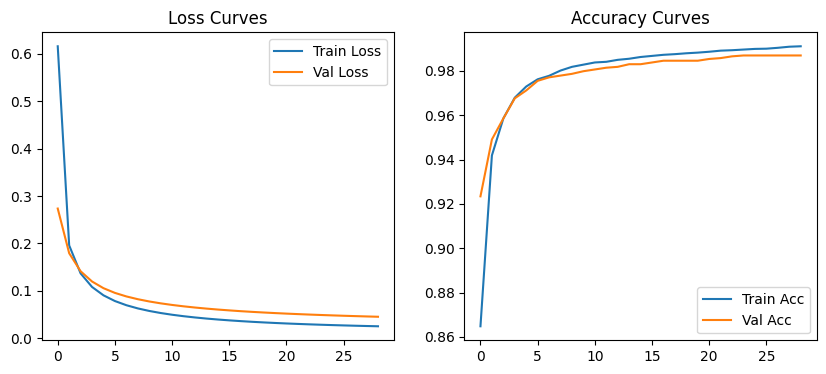

In [59]:
import matplotlib.pyplot as plt

# Comparing train vs. validation helps diagnose model generalization.

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")
# Show if the model is learning and if there’s overfitting/underfitting.

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()
# Measure classification performance over epochs.


####Step 8 – Test set evaluation and confusion matrix

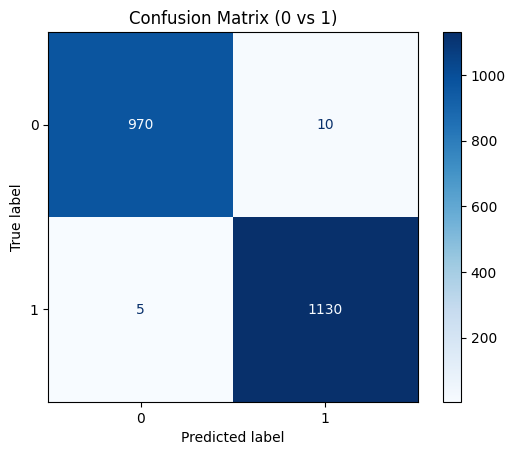

Test Accuracy: 0.9929078014184397


In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

with torch.no_grad():      # No gradients during evaluation
    y_true_list, y_pred_list = [], []
    for X_batch, y_batch in test_loader_bin:
        y_batch = y_batch.view(-1, 1)

        y_pred = logistic_regression(X_batch)
        preds = (y_pred >= 0.5).long()

        y_true_list.extend(y_batch.view(-1).numpy())
        y_pred_list.extend(preds.view(-1).numpy())
        # Save true labels and predicted labels for later analysis


# Compute and plot confusion matrix
# breaks results into TP, FP, TN, FN for deeper insight than accuracy alone.
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (0 vs 1)")
plt.show()

# Final test gives the overall accuracy.
print("Test Accuracy:", (cm.diagonal().sum() / cm.sum()))


## **A3. Softmax Regression Implementation**

### Concept Recap:
### Binary Logistic Regression (review)
- Output: single logit → sigmoid → probability of class 1
- Loss: Binary Cross-Entropy

### Softmax Regression (multi-class)
- Output: one logit per class → softmax → probability distribution
- Loss: Multi-class Cross-Entropy

### Mathematically:
- ŷ = softmax(XW + b)

- Loss = - (1/N) Σ log( ŷ[i, y_i] )

##### Where:
- ŷ[i, y_i] = predicted probability for the correct class of example i
- N = number of samples

## Step 1 - Model Definition (from scratch)




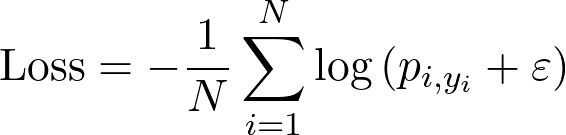

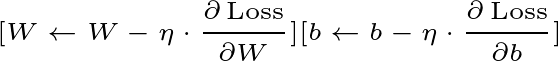

In [25]:
import torch

class SoftmaxRegression:
    def __init__(self, input_dim, num_classes, lr=0.01):
        # Weight matrix: shape (features, classes) = (784, 10)
        # Each column corresponds to one class’s weights
        self.W = torch.zeros((input_dim, num_classes), dtype=torch.float32, requires_grad=True)

        # Bias vector: one bias per class (num_classes,)
        self.b = torch.zeros((num_classes,), dtype=torch.float32, requires_grad=True)

        # Learning rate
        self.lr = lr

    def forward(self, X):
        # Compute logits (raw scores before softmax)
        logits = X @ self.W + self.b  # shape: (batch_size, num_classes)

        # Numerical stability trick: subtract max logit in each row
        # Example: logits = [1000, 1001, 999]
        # torch.exp(logits) → [inf, inf, inf]  # overflow
        # max = 1001, shifted = [-1, 0, -2], torch.exp(shifted) → safe
        exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True)[0])

        # Convert to probabilities by dividing each row by the sum
        probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)
        return probs

    def compute_loss(self, probs, y):
        # Cross-entropy loss for multi-class classification
        N = y.shape[0]
        log_probs = torch.log(probs[range(N), y] + 1e-9)  # +1e-9 to avoid log(0)
        loss = -torch.sum(log_probs) / N
        return loss

    def step(self):
        # Manual gradient descent update
        with torch.no_grad():
            self.W -= self.lr * self.W.grad  # update weights
            self.b -= self.lr * self.b.grad  # update biases
            # Reset gradients to zero
            self.W.grad.zero_()
            self.b.grad.zero_()


| Variable        | Shape                       | Example     | Description                            |
| --------------- | --------------------------- | ----------- | -------------------------------------- |
| **`X`**         | `(batch_size, input_dim)`   | `(64, 784)` | Batch of flattened images              |
| **`W`**         | `(input_dim, num_classes)`  | `(784, 10)` | Weight matrix                          |
| **`b`**         | `(num_classes,)`            | `(10,)`     | One bias per class                     |
| **`X @ W`**     | `(batch_size, num_classes)` | `(64, 10)`  | Raw logits for each sample             |
| **`X @ W + b`** | `(batch_size, num_classes)` | `(64, 10)`  | Bias broadcast across batch            |
| **Row meaning** | —                           | —           | Each row has 10 logits (one per class) |


## Step 2 - Training and Validation Loop

In [26]:
def train_softmax(model, train_loader, val_loader, epochs=50, patience=5, min_delta=1e-4):
    """
    Train a softmax regression model with early stopping and best model tracking.
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    wait = 0
    best_model_state = None

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            # Flatten if needed
            X_batch = X_batch.view(X_batch.size(0), -1) if X_batch.dim() > 2 else X_batch

            # Zero gradients if previously set
            if model.W.grad is not None: model.W.grad.zero_()
            if model.b.grad is not None: model.b.grad.zero_()

            # Forward pass
            probs = model.forward(X_batch)
            loss = model.compute_loss(probs, y_batch)

            # Backward pass and manual gradient descent
            loss.backward()
            model.step()

            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.view(X_val.size(0), -1) if X_val.dim() > 2 else X_val
                probs = model.forward(X_val)
                loss = model.compute_loss(probs, y_val)

                val_loss += loss.item()
                preds = torch.argmax(probs, dim=1)
                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accs[-1]:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            wait = 0
            best_model_state = {'W': model.W.clone(), 'b': model.b.clone()}
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                if best_model_state is not None:
                    model.W = best_model_state['W'].clone()
                    model.b = best_model_state['b'].clone()
                break

    return train_losses, val_losses, train_accs, val_accs, best_model_state


## Step 3 - Train From-Scratch Model

In [63]:
import time

# Hyperparameters
input_dim = 28 * 28      # 28x28 pixels flattened
num_classes = 10         # digits 0-9
lr = 0.01                # learning rate
epochs = 50              # max epochs
patience = 10            # early stopping patience
min_delta = 1e-4         # minimum improvement

# Initialize model
scratch_model = SoftmaxRegression(input_dim, num_classes, lr)

# --- Train the model AND time the process ---
print("--- Starting From-Scratch Softmax Regression Training ---")

# 1. Record the start time
start_time_soft = time.time()

# Train model
train_losses, val_losses, train_accs, val_accs, best_model_state = train_softmax(
    scratch_model,
    train_loader_flat,
    val_loader_flat,
    epochs=epochs,
    patience=patience,
    min_delta=min_delta
)

# 2. Record the end time and calculate the duration
end_time_soft = time.time()
soft_train_time = end_time_soft - start_time_soft

# Load best model weights
scratch_model.W = best_model_state['W'].clone()
scratch_model.b = best_model_state['b'].clone()

# --- Store the final metrics for the comparison table ---
# Get the accuracy/loss from the epoch with the best validation loss
best_epoch_index = val_losses.index(min(val_losses))
softmax_val_acc = val_accs[best_epoch_index]
softmax_val_loss = val_losses[best_epoch_index]


print("\n--- From-Scratch Softmax Training Complete ---")
print(f"Total Training Time: {soft_train_time:.2f} seconds")
print(f"Best Validation Accuracy: {softmax_val_acc:.4f}")
print(f"Best Validation Loss: {softmax_val_loss:.4f}")

--- Starting From-Scratch Softmax Regression Training ---
Epoch 1/50 | Train Loss: 1.0591 | Train Acc: 0.8074 | Val Loss: 0.6810 | Val Acc: 0.8532
Epoch 2/50 | Train Loss: 0.5928 | Train Acc: 0.8631 | Val Loss: 0.5364 | Val Acc: 0.8692
Epoch 3/50 | Train Loss: 0.5012 | Train Acc: 0.8749 | Val Loss: 0.4773 | Val Acc: 0.8782
Epoch 4/50 | Train Loss: 0.4566 | Train Acc: 0.8820 | Val Loss: 0.4438 | Val Acc: 0.8838
Epoch 5/50 | Train Loss: 0.4291 | Train Acc: 0.8871 | Val Loss: 0.4217 | Val Acc: 0.8878
Epoch 6/50 | Train Loss: 0.4100 | Train Acc: 0.8906 | Val Loss: 0.4058 | Val Acc: 0.8908
Epoch 7/50 | Train Loss: 0.3957 | Train Acc: 0.8937 | Val Loss: 0.3939 | Val Acc: 0.8928
Epoch 8/50 | Train Loss: 0.3845 | Train Acc: 0.8962 | Val Loss: 0.3840 | Val Acc: 0.8956
Epoch 9/50 | Train Loss: 0.3753 | Train Acc: 0.8979 | Val Loss: 0.3758 | Val Acc: 0.8976
Epoch 10/50 | Train Loss: 0.3677 | Train Acc: 0.8996 | Val Loss: 0.3692 | Val Acc: 0.8996
Epoch 11/50 | Train Loss: 0.3613 | Train Acc: 0.900

## Step 4 - Plot Training/Validation Metrics (Loss & Accuracy)

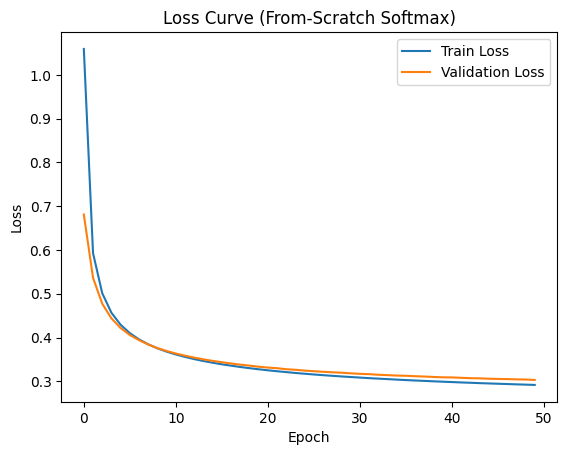

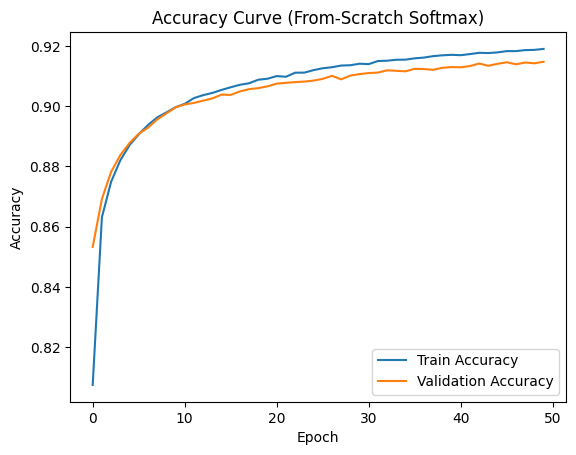

In [64]:
import matplotlib.pyplot as plt

# Loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curve (From-Scratch Softmax)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Accuracy curves
plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve (From-Scratch Softmax)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()import time
import torch.nn.functional as F

# Ensure your tensors are on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w = w.to(device)
b = b.to(device)

patience = 15
epochs_no_improve = 0

total_start_time = time.time()

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss, correct, total = 0, 0, 0

    # Training
    for X_batch, y_batch in train_loader_bin:
        X_batch = X_batch.to(device)
        y_batch = y_batch.view(-1, 1).to(device)

        # Forward pass: logistic regression with sigmoid
        y_pred = torch.sigmoid(logistic_regression(X_batch))  # Apply sigmoid
        loss = F.binary_cross_entropy(y_pred, y_batch)        # BCE loss

        # Backward pass
        loss.backward()

        # Update parameters manually
        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad
            w.grad.zero_()
            b.grad.zero_()

        # Track metrics
        epoch_loss += loss.item() * X_batch.size(0)
        preds = (y_pred >= 0.5).long()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_bin:
            X_batch = X_batch.to(device)
            y_batch = y_batch.view(-1, 1).to(device)

            y_pred = torch.sigmoid(logistic_regression(X_batch))
            loss = F.binary_cross_entropy(y_pred, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (y_pred >= 0.5).long()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

    # Early stopping
    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        best_val_loss = val_losses[-1]
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | Time: {epoch_time:.2f}s")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1} "
              f"with best val acc: {best_val_acc:.4f}, val loss: {best_val_loss:.4f}")
        break

total_time = time.time() - total_start_time
print(f"\nTotal Training Time: {total_time:.2f} seconds")


## Step 5 - Test Evaluation (Confusion Matrix & Per-Class Accuracy)



Confusion Matrix (from-scratch):
 [[ 961    0    3    2    0    3    8    1    2    0]
 [   0 1108    2    2    0    2    4    2   15    0]
 [   7    9  908   18   12    2   15   13   41    7]
 [   3    0   23  920    0   27    2   11   17    7]
 [   1    3    4    1  913    0   13    2    8   37]
 [  11    3    3   35    9  767   18    6   33    7]
 [  12    3    4    2   11   11  912    2    1    0]
 [   3   12   21    9    6    1    0  941    3   32]
 [   8    8    6   24    9   27   12   13  858    9]
 [  12    7    2   11   39    5    0   26    7  900]]

Classification Report (from-scratch):
              precision    recall  f1-score   support

           0     0.9440    0.9806    0.9620       980
           1     0.9610    0.9762    0.9685      1135
           2     0.9303    0.8798    0.9044      1032
           3     0.8984    0.9109    0.9046      1010
           4     0.9139    0.9297    0.9218       982
           5     0.9077    0.8599    0.8831       892
           6     

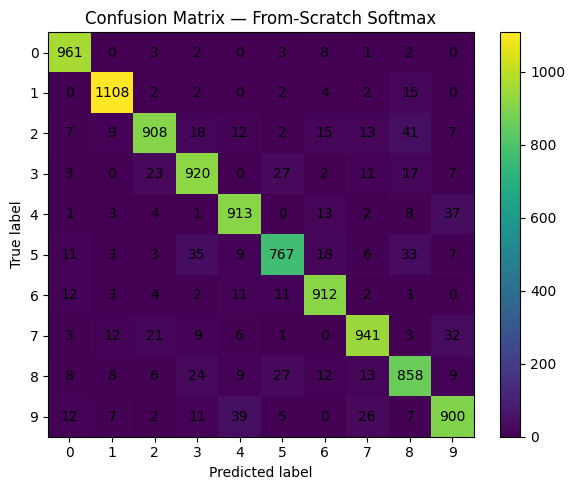

In [65]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt

y_true, y_pred = [], []  # Will hold all true labels and predicted labels

with torch.no_grad():  # No gradients needed for evaluation

    for X_batch, y_batch in test_loader_flat:  # Use your dataset loader
        X_batch = X_batch.view(X_batch.size(0), -1)  # Flatten input features
        probs = scratch_model.forward(X_batch)  # Get class probabilities from model
        preds = torch.argmax(probs, dim=1)  # Pick the class with highest probability

        y_true.extend(y_batch.tolist())  # Accumulate ground-truth labels
        y_pred.extend(preds.tolist())  # Accumulate predicted labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)  # Rows = true classes, Columns = predicted classes
print("Confusion Matrix (from-scratch):\n", cm)

# Per-class report (precision/recall/f1/support)
# Also gives you an indirect view of per-class accuracy via recall.
print("\nClassification Report (from-scratch):")
print(classification_report(y_true, y_pred, digits=4))

# # Optional:
# # compute explicit per-class accuracy = cm[i,i] / sum(cm[i,:])
# per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)  # clip to avoid divide-by-zero
# for c, acc in enumerate(per_class_acc):
#     print(f"Class {c}: accuracy = {acc:.4f}")

# Simple matplotlib heatmap for the CM (no seaborn dependency)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Confusion Matrix — From-Scratch Softmax")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Annotate counts inside each cell for readability
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


## Step 6 - Built-in PyTorch Implementation for Verification

In [61]:
import torch.nn as nn
import torch.optim as optim
import time

# Assuming 'input_dim', 'num_classes', 'lr', 'train_loader_flat',
# and 'val_loader_flat' are defined in a previous cell.
epochs = 50

class SoftmaxRegressionBuiltIn(nn.Module):
    # Single linear layer producing logits for 10 classes.
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Flattening is handled by the training loop, but this is a good defensive measure
        x = x.view(x.size(0), -1)
        return self.linear(x) # Return raw logits

# Instantiate the model and move it to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
built_model = SoftmaxRegressionBuiltIn(input_dim, num_classes).to(device)

# Criterion and Optimizer
criterion_bi = nn.CrossEntropyLoss()
optimizer_bi = optim.SGD(built_model.parameters(), lr=lr)

# Containers for metrics
train_losses_bi, val_losses_bi = [], []
train_accs_bi, val_accs_bi = [], []

# Early stopping parameters
best_val_loss = float('inf')
patience = 10 # Increased patience slightly for more stable models
counter = 0

# --- Training and Validation ---
print("--- Starting Built-in Softmax Regression Training ---")

# 1. Record the start time
start_time_soft_bi = time.time()

for epoch in range(epochs):
    # Training
    built_model.train()
    epoch_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader_flat:
        # Move data to the device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = built_model(X_batch)
        loss = criterion_bi(logits, y_batch)

        optimizer_bi.zero_grad()
        loss.backward()
        optimizer_bi.step()

        # Metrics accumulation
        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses_bi.append(epoch_loss / len(train_loader_flat))
    train_accs_bi.append(correct / total)

    # Validation
    built_model.eval()
    epoch_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_flat:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = built_model(X_batch)
            loss = criterion_bi(logits, y_batch)

            epoch_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_losses_bi.append(epoch_val_loss / len(val_loader_flat))
    val_accs_bi.append(correct_val / total_val)

    # Progress printout
    print(f"[Built-in] Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses_bi[-1]:.4f}, Train Acc: {train_accs_bi[-1]:.4f} | "
          f"Val Loss: {val_losses_bi[-1]:.4f}, Val Acc: {val_accs_bi[-1]:.4f}")

    # Early stopping check
    if val_losses_bi[-1] < best_val_loss:
        best_val_loss = val_losses_bi[-1]
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# 2. Record the end time and calculate the total duration
end_time_soft_bi = time.time()
soft_bi_train_time = end_time_soft_bi - start_time_soft_bi

# 3. Store the final metrics for the comparison table
soft_bi_val_acc = val_accs_bi[-1]
soft_bi_val_loss = val_losses_bi[-1]

print("\n--- Built-in Softmax Training Complete ---")
print(f"Total Training Time: {soft_bi_train_time:.2f} seconds")
print(f"Final Validation Accuracy: {soft_bi_val_acc:.4f}")
print(f"Final Validation Loss: {soft_bi_val_loss:.4f}")

--- Starting Built-in Softmax Regression Training ---
[Built-in] Epoch 1/50 | Train Loss: 1.0752, Train Acc: 0.7816 | Val Loss: 0.6855, Val Acc: 0.8499
[Built-in] Epoch 2/50 | Train Loss: 0.5956, Train Acc: 0.8615 | Val Loss: 0.5381, Val Acc: 0.8693
[Built-in] Epoch 3/50 | Train Loss: 0.5025, Train Acc: 0.8745 | Val Loss: 0.4785, Val Acc: 0.8788
[Built-in] Epoch 4/50 | Train Loss: 0.4575, Train Acc: 0.8819 | Val Loss: 0.4447, Val Acc: 0.8832
[Built-in] Epoch 5/50 | Train Loss: 0.4298, Train Acc: 0.8873 | Val Loss: 0.4227, Val Acc: 0.8868
[Built-in] Epoch 6/50 | Train Loss: 0.4106, Train Acc: 0.8901 | Val Loss: 0.4065, Val Acc: 0.8913
[Built-in] Epoch 7/50 | Train Loss: 0.3962, Train Acc: 0.8932 | Val Loss: 0.3944, Val Acc: 0.8932
[Built-in] Epoch 8/50 | Train Loss: 0.3850, Train Acc: 0.8960 | Val Loss: 0.3844, Val Acc: 0.8958
[Built-in] Epoch 9/50 | Train Loss: 0.3757, Train Acc: 0.8981 | Val Loss: 0.3766, Val Acc: 0.8967
[Built-in] Epoch 10/50 | Train Loss: 0.3681, Train Acc: 0.8993 |

## Step 7 - Compare Curves + Built-in Test Evaluation

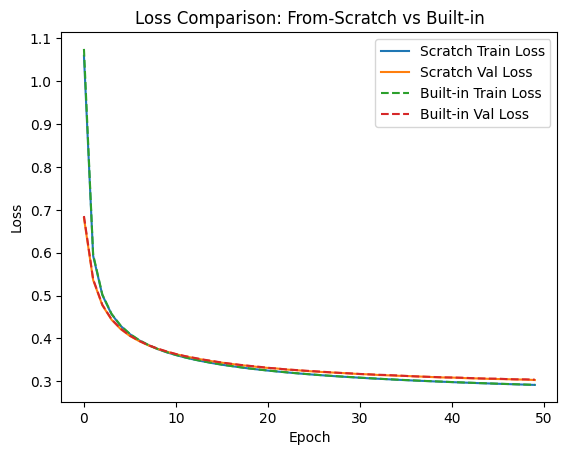

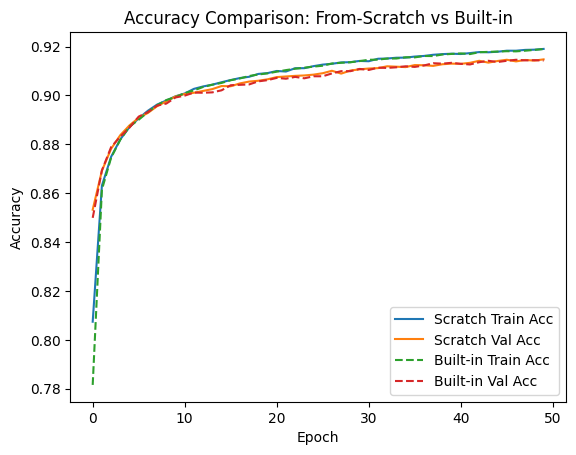

Confusion Matrix (built-in):
 [[ 962    0    2    3    0    3    7    1    2    0]
 [   0 1107    2    2    0    3    4    1   16    0]
 [   7    9  910   17   12    3   12   13   41    8]
 [   3    0   20  923    0   26    2   10   18    8]
 [   2    3    3    1  914    0   11    2    8   38]
 [  10    3    3   40    9  766   16    6   32    7]
 [  12    3    4    2   11   13  910    2    1    0]
 [   3   12   22    9    6    1    0  936    3   36]
 [   8    6    6   25    9   28   12   10  861    9]
 [  12    7    2   11   38    5    0   21    7  906]]

Classification Report (built-in):
              precision    recall  f1-score   support

           0     0.9441    0.9816    0.9625       980
           1     0.9626    0.9753    0.9689      1135
           2     0.9343    0.8818    0.9073      1032
           3     0.8935    0.9139    0.9036      1010
           4     0.9149    0.9308    0.9228       982
           5     0.9033    0.8587    0.8805       892
           6     0.9343  

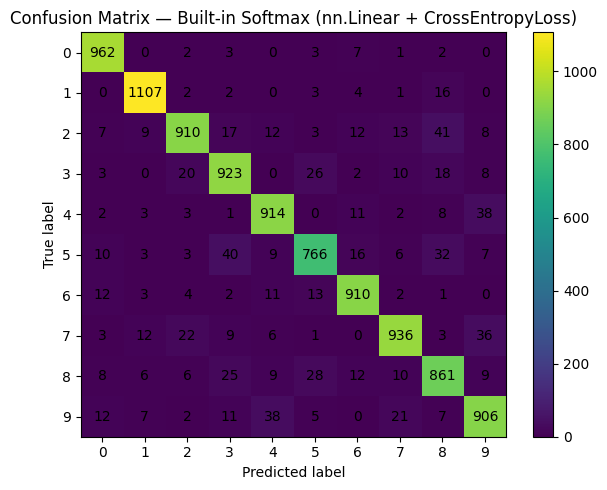

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ===== Compare Loss Curves (Scratch vs Built-in) =====
plt.figure()
plt.plot(train_losses,    label="Scratch Train Loss")
plt.plot(val_losses,      label="Scratch Val Loss")
plt.plot(train_losses_bi, label="Built-in Train Loss", linestyle="--")
plt.plot(val_losses_bi,   label="Built-in Val Loss",   linestyle="--")
plt.legend()
plt.title("Loss Comparison: From-Scratch vs Built-in")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# ===== Compare Accuracy Curves =====
plt.figure()
plt.plot(train_accs,    label="Scratch Train Acc")
plt.plot(val_accs,      label="Scratch Val Acc")
plt.plot(train_accs_bi, label="Built-in Train Acc", linestyle="--")
plt.plot(val_accs_bi,   label="Built-in Val Acc",   linestyle="--")
plt.legend()
plt.title("Accuracy Comparison: From-Scratch vs Built-in")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


# ===== Built-in: Test Confusion Matrix and Per-class Accuracy =====
y_true_bi, y_pred_bi = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_flat:
        # Move inputs and labels to same device as model
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = built_model(X_batch)                # Logits from built-in model
        preds = torch.argmax(logits, dim=1)         # Predicted class indices

        # Move back to CPU for sklearn compatibility
        y_true_bi.extend(y_batch.cpu().tolist())
        y_pred_bi.extend(preds.cpu().tolist())

# Confusion matrix
cm_bi = confusion_matrix(y_true_bi, y_pred_bi)
print("Confusion Matrix (built-in):\n", cm_bi)

# Classification report
print("\nClassification Report (built-in):")
print(classification_report(y_true_bi, y_pred_bi, digits=4))

# Per-class accuracy
per_class_acc_bi = cm_bi.diagonal() / cm_bi.sum(axis=1).clip(min=1)
for c, acc in enumerate(per_class_acc_bi):
    print(f"Class {c}: accuracy = {acc:.4f}")

# Matplotlib-only heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm_bi, interpolation='nearest', aspect='auto')
plt.title("Confusion Matrix — Built-in Softmax (nn.Linear + CrossEntropyLoss)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted label")
plt.ylabel("True label")
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm_bi[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


# **Part B: Neural Network Implementation**







## **B1. Custom Neural Network Architecture**

In [67]:
# ===== Part B: Neural Network Implementation =====
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# ----- B1. Custom Feedforward Neural Network -----
class FeedforwardNN(nn.Module):
    """
    Two-hidden-layer MLP for MNIST.
    Input -> Hidden1 -> Hidden2 -> Output
    Uses ReLU for hidden layers.
    Flexible architecture with Xavier weight initialization.
    """
    def __init__(self, input_size=784, hidden1=256, hidden2=128, num_classes=10):
        super().__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(input_size, hidden1)    # Input -> Hidden1
        self.fc2 = nn.Linear(hidden1, hidden2)       # Hidden1 -> Hidden2
        self.fc3 = nn.Linear(hidden2, num_classes)   # Hidden2 -> Output

        # ReLU activations
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        """
        Forward pass for flattened input (B, 784)
        """
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # raw logits for CrossEntropyLoss
        return x


| Layer | From | To  | Purpose                            |
| ----- | ---- | --- | ---------------------------------- |
| `fc1` | 784  | 256 | Raw pixels → first hidden features |
| `fc2` | 256  | 128 | First features → refined features  |
| `fc3` | 128  | 10  | Refined features → class scores    |


#B2 Training Infrastructure
-Custom training loop (from scratch, not using fit).

-Batch processing with DataLoader (batch_size=64).

Proper gradient handling: optimizer.zero_grad() → loss.

backward() → optimizer.step().

Train/validation split: done with random_split.

Progress logging each epoch with losses and accuracies.

SGD optimizer with learning rate 0.01.

CrossEntropyLoss for classification.

In [68]:
import torch
import torch.nn as nn

def train_model_custom(model, train_loader, val_loader, optimizer=None, criterion=None,
                       epochs=50, patience=15, device='cpu', lr=0.01):
    """
    Custom training loop with:
    - Batch processing
    - Backpropagation
    - Validation tracking
    - Early stopping
    - Optional learning rate adjustment
    """

    # If optimizer or criterion not provided, use defaults
    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    # Lists to store metrics for each epoch
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    wait = 0  # counter for early stopping

    model.to(device)  # move model to CPU/GPU

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Flatten input for feedforward model
            X_batch = X_batch.view(X_batch.size(0), -1)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Zero gradients, backprop, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training metrics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        # Save training metrics for this epoch
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                # Move data to device
                X_val, y_val = X_val.to(device), y_val.to(device)
                
                # Flatten input for feedforward model
                X_val = X_val.view(X_val.size(0), -1)

                # Forward pass
                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                # Accumulate validation metrics
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)

        # Save validation metrics for this epoch
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        # ---- Logging ----
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

        # ---- Early Stopping ----
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            wait = 0  # reset early stopping counter
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Return all collected metrics
    return train_losses, val_losses, train_accs, val_accs


In [ ]:
# nn.Dropout(p=0.5)
# A regularization technique to prevent overfitting.
# During training, it randomly sets some neurons’ outputs to 0 with probability p.
# During training, half of the neurons are ignored randomly.
# → During evaluation (model.eval()), dropout is disabled and all neurons are used

In [75]:
import time
import copy  # For deep copying the best model

# ----- B3. Training Setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 50
patience = 15
learning_rate = 0.01

model = FeedforwardNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Variables for early stopping and best model
best_val_acc = 0.0
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')  # Track validation loss at best accuracy

# ----- B3. Train the network AND time the process -----
print("--- Starting Neural Network Training ---")
start_time_nn = time.time()

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader_flat:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.size(0), -1)  # flatten

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_flat:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    # Early stopping and best model tracking
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_val_loss = val_losses[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | "
          f"Val Acc: {val_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1} "
              f"with best val acc: {best_val_acc:.4f} and val loss: {best_val_loss:.4f}")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Record total training time
nn_train_time = time.time() - start_time_nn

print(f"\n--- Neural Network Training Complete ---")
print(f"Total Training Time: {nn_train_time:.2f} seconds")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Validation Loss at Best Accuracy: {best_val_loss:.4f}")


--- Starting Neural Network Training ---
Epoch 1/50 | Train Acc: 0.7782 | Val Acc: 0.8833 | Val Loss: 0.4477
Epoch 2/50 | Train Acc: 0.8938 | Val Acc: 0.9048 | Val Loss: 0.3413
Epoch 3/50 | Train Acc: 0.9094 | Val Acc: 0.9143 | Val Loss: 0.3011
Epoch 4/50 | Train Acc: 0.9186 | Val Acc: 0.9210 | Val Loss: 0.2766
Epoch 5/50 | Train Acc: 0.9264 | Val Acc: 0.9273 | Val Loss: 0.2535
Epoch 6/50 | Train Acc: 0.9315 | Val Acc: 0.9325 | Val Loss: 0.2365
Epoch 7/50 | Train Acc: 0.9375 | Val Acc: 0.9353 | Val Loss: 0.2239
Epoch 8/50 | Train Acc: 0.9411 | Val Acc: 0.9397 | Val Loss: 0.2113
Epoch 9/50 | Train Acc: 0.9446 | Val Acc: 0.9423 | Val Loss: 0.2030
Epoch 10/50 | Train Acc: 0.9479 | Val Acc: 0.9453 | Val Loss: 0.1907
Epoch 11/50 | Train Acc: 0.9515 | Val Acc: 0.9457 | Val Loss: 0.1885
Epoch 12/50 | Train Acc: 0.9534 | Val Acc: 0.9507 | Val Loss: 0.1769
Epoch 13/50 | Train Acc: 0.9558 | Val Acc: 0.9513 | Val Loss: 0.1695
Epoch 14/50 | Train Acc: 0.9578 | Val Acc: 0.9524 | Val Loss: 0.1637
Ep

#B3

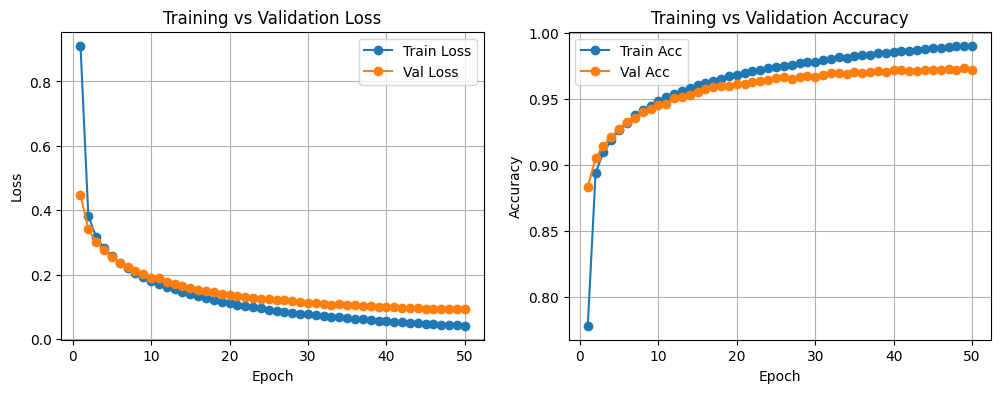

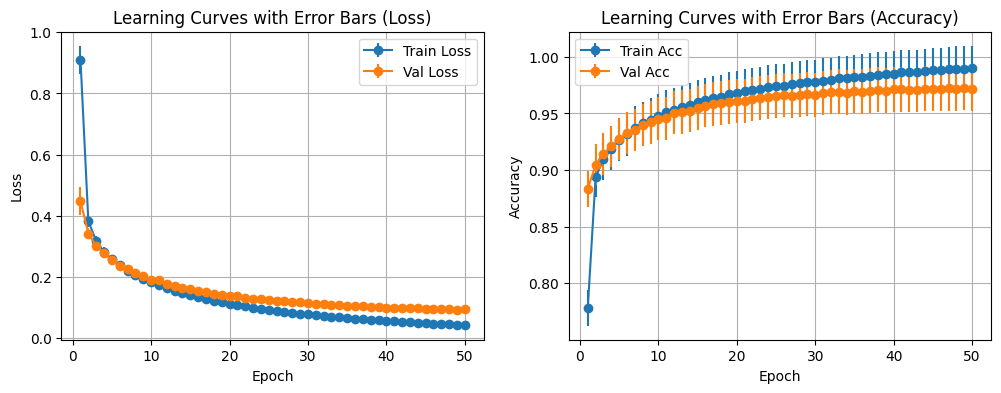

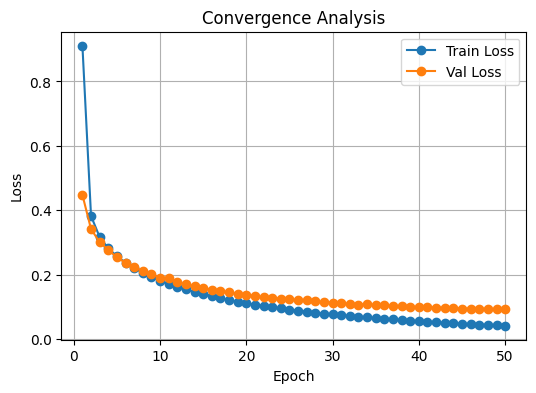

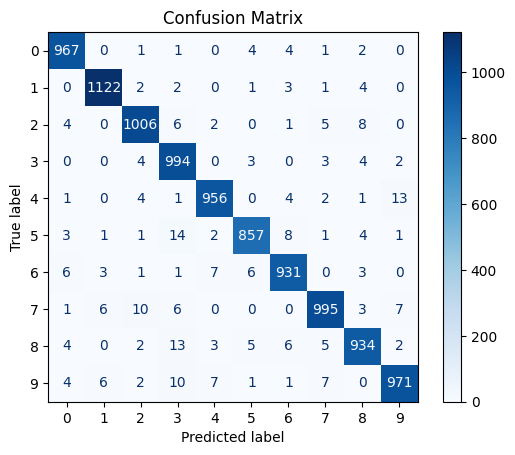

Test Accuracy: 0.9733
--- Classification Report ---
              precision    recall  f1-score   support

           0     0.9768    0.9867    0.9817       980
           1     0.9859    0.9885    0.9872      1135
           2     0.9739    0.9748    0.9743      1032
           3     0.9485    0.9842    0.9660      1010
           4     0.9785    0.9735    0.9760       982
           5     0.9772    0.9608    0.9689       892
           6     0.9718    0.9718    0.9718       958
           7     0.9755    0.9679    0.9717      1028
           8     0.9699    0.9589    0.9644       974
           9     0.9749    0.9623    0.9686      1009

    accuracy                         0.9733     10000
   macro avg     0.9733    0.9730    0.9731     10000
weighted avg     0.9734    0.9733    0.9733     10000



In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import torch

# --- Epoch range for plotting ---
epochs_range = range(1, len(train_losses) + 1)

# ----- 2. Training & Validation Loss -----
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ----- 3. Training & Validation Accuracy -----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc", marker='o')
plt.plot(epochs_range, val_accs, label="Val Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ----- 4. Learning Curves with Error Bars -----
train_losses_arr = np.array(train_losses)
val_losses_arr = np.array(val_losses)
train_accs_arr = np.array(train_accs)
val_accs_arr = np.array(val_accs)

loss_std = 0.05 * train_losses_arr  # 5% simulated error
acc_std = 0.02 * train_accs_arr     # 2% simulated error

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.errorbar(epochs_range, train_losses_arr, yerr=loss_std, label="Train Loss", fmt='-o')
plt.errorbar(epochs_range, val_losses_arr, yerr=loss_std, label="Val Loss", fmt='-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves with Error Bars (Loss)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.errorbar(epochs_range, train_accs_arr, yerr=acc_std, label="Train Acc", fmt='-o')
plt.errorbar(epochs_range, val_accs_arr, yerr=acc_std, label="Val Acc", fmt='-o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curves with Error Bars (Accuracy)")
plt.legend()
plt.grid(True)
plt.show()

# ----- 5. Convergence Analysis (Loss vs Epoch) -----
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses_arr, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses_arr, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence Analysis")
plt.legend()
plt.grid(True)
plt.show()

# ----- 6. Confusion Matrix & Test Accuracy -----
model.eval()  # Use 'model' which already has the best weights loaded
y_true, y_pred = [], []

with torch.no_grad():
    for X_test, y_test in test_loader_flat:
        X_test = X_test.view(X_test.size(0), -1)
        outputs = model(X_test.to(device))
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y_test.tolist())
        y_pred.extend(preds.cpu().tolist())

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Test accuracy
test_acc = sum([yt == yp for yt, yp in zip(y_true, y_pred)]) / len(y_true)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
class_names = [str(i) for i in range(10)]
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


Using device: cuda


In [80]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# ------------------------------
# Data augmentation and normalization for CNN
# ------------------------------
transform_train_cnn = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full training dataset with augmentations
full_train_dataset_cnn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train_cnn)

# Split the augmented training set into new train/val sets
train_size = 48000
val_size = len(full_train_dataset_cnn) - train_size
train_dataset_aug, val_dataset_aug = random_split(full_train_dataset_cnn, [train_size, val_size])

# Load the test dataset with normalization
test_dataset_norm = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test_cnn)

# Create DataLoaders for the CNN
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_norm, batch_size=batch_size, shuffle=False)

print(f"Number of batches for CNN (train): {len(train_loader_cnn)}, "
      f"(val): {len(val_loader_cnn)}, (test): {len(test_loader_cnn)}")


Number of batches for CNN (train): 750, (val): 188, (test): 157


In [81]:
import torch.nn as nn
import torch.nn.functional as F

class AdvancedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5, use_batchnorm=True):
        super(AdvancedCNN, self).__init__()
        self.use_batchnorm = use_batchnorm

        # ---- Convolutional Block 1 ----
        # Input: 28x28x1 -> Output: 14x14x32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(32)
        
        # ---- Convolutional Block 2 ----
        # Input: 14x14x32 -> Output: 7x7x64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm2d(64)
            
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # ---- Fully Connected Layer ----
        # Flattened output from Block 2 is 7*7*64 = 3136
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten and Classify
        x = x.view(-1, 7 * 7 * 64) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [82]:
import copy
from tqdm import tqdm  # for progress bar

def train_model_bn_dropout(model, train_loader, val_loader, num_epochs=20, lr=0.01, patience=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    epochs_no_improve = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()  # enables dropout & batchnorm
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(train_loss=running_loss/total, train_acc=correct/total)

        train_loss_epoch = running_loss / total
        train_acc_epoch = correct / total
        train_losses.append(train_loss_epoch)
        train_accs.append(train_acc_epoch)

        # Validation
        model.eval()  # disables dropout
        val_loss_total, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss_epoch = val_loss_total / val_total
        val_acc_epoch = val_correct / val_total
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)

        # Print metrics for this epoch
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | "
              f"Train Acc: {train_acc_epoch:.4f} | Val Acc: {val_acc_epoch:.4f}")

        # Early stopping
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load the best model
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs


In [ ]:
from torchsummary import summary

# Instantiate the model with your desired parameters
model = AdvancedCNN(dropout_rate=0.3, use_batchnorm=True).to(device)

# Print the summary
# The (1, 28, 28) is the input shape (channels, height, width)
print("---------- Model Summary ----------")
summary(model, (1, 28, 28))

# Choose a dropout rate
dropout_rate = 0.3

# Create the model
model = AdvancedCNN(dropout_rate=dropout_rate, use_batchnorm=True).to(device)

# --- Print Model Architecture ---
print("Model Architecture:")
print(model)

# --- Get a single sample image ---
sample_img, sample_label = next(iter(train_loader_cnn))
sample_img = sample_img[0].unsqueeze(0).to(device)  # first image, add batch dim

print(f"\nSample image shape: {sample_img.shape}, Label: {sample_label[0].item()}")

# --- Forward pass through conv/pool layers only ---
model.eval()
x = sample_img
print("\nForward pass through CNN to show feature map sizes:")
for name, layer in model.named_children():
    # Stop before the fully connected layers
    if isinstance(layer, torch.nn.Linear):
        break

    x = layer(x)
    if isinstance(layer, (torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.BatchNorm2d, torch.nn.ReLU, torch.nn.Dropout)):
        print(f"Layer: {name:15} | Output shape: {x.shape}")


In [85]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm

def train_advanced_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, patience=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=3, verbose=True)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    epochs_no_improve = 0
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(train_loss=running_loss/total, train_acc=correct/total)
        
        train_loss_epoch = running_loss / total
        train_acc_epoch = correct / total
        train_losses.append(train_loss_epoch)
        train_accs.append(train_acc_epoch)

        # Validation
        model.eval()
        val_loss_total, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss_epoch = val_loss_total / val_total
        val_acc_epoch = val_correct / val_total
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.4f} | Val Acc: {val_acc_epoch:.4f}")
        
        # Scheduler step
        scheduler.step(val_acc_epoch)

        # Save best model weights
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model + all metrics + best model weights
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_model_wts': best_model_wts,
        'best_val_acc': best_val_acc
    }


In [ ]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results_dropout = {}

for rate in dropout_rates:
    print(f"\n--- Training AdvancedCNN with Dropout rate = {rate} ---")
    model = AdvancedCNN(dropout_rate=rate, use_batchnorm=True)

    # Use the new CNN data loaders with augmentation
    result = train_advanced_model(model, train_loader_cnn, val_loader_cnn, num_epochs=20, lr=0.001, patience=5)

    results_dropout[f"Dropout={rate}"] = result  # Save everything

    print(f"Dropout={rate} | Best Validation Accuracy: {result['best_val_acc']:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Training AdvancedCNN with Dropout rate = 0.1 ---


Epoch 1/20 | Train Loss: 0.1819 | Val Loss: 0.0794 | Train Acc: 0.9434 | Val Acc: 0.9765


Epoch 2/20 | Train Loss: 0.0713 | Val Loss: 0.0637 | Train Acc: 0.9785 | Val Acc: 0.9794


Epoch 3/20 | Train Loss: 0.0587 | Val Loss: 0.0644 | Train Acc: 0.9819 | Val Acc: 0.9813


Epoch 4/20 | Train Loss: 0.0520 | Val Loss: 0.0576 | Train Acc: 0.9846 | Val Acc: 0.9831


Epoch 5/20 | Train Loss: 0.0483 | Val Loss: 0.0466 | Train Acc: 0.9854 | Val Acc: 0.9866


Epoch 6/20 | Train Loss: 0.0473 | Val Loss: 0.0500 | Train Acc: 0.9860 | Val Acc: 0.9843


Epoch 7/20 | Train Loss: 0.0443 | Val Loss: 0.0500 | Train Acc: 0.9869 | Val Acc: 0.9842


Epoch 8/20 | Train Loss: 0.0424 | Val Loss: 0.0376 | Train Acc: 0.9876 | Val Acc: 0.9899


Epoch 9/20 | Train Loss: 0.0375 | Val Loss: 0.0425 | Train Acc: 0.9890 | Val Acc: 0.9875


Epoch 10/20 | Train Loss: 0.0392 | Val Loss: 0.0385 | Train Acc: 0.9888 | Val Acc: 0.9904


Epoch 11/20 | Train Loss: 0.0361 | Val Loss: 0.0458 | Train Acc: 0.9890 | Val Acc: 0.9873


Epoch 12/20 | Train Loss: 0.0330 | Val Loss: 0.0558 | Train Acc: 0.9908 | Val Acc: 0.9841


Epoch 13/20 | Train Loss: 0.0318 | Val Loss: 0.0355 | Train Acc: 0.9908 | Val Acc: 0.9902


Epoch 14/20 | Train Loss: 0.0319 | Val Loss: 0.0358 | Train Acc: 0.9909 | Val Acc: 0.9898


Epoch 15/20 | Train Loss: 0.0237 | Val Loss: 0.0268 | Train Acc: 0.9932 | Val Acc: 0.9924


Epoch 16/20 | Train Loss: 0.0191 | Val Loss: 0.0274 | Train Acc: 0.9944 | Val Acc: 0.9921


Epoch 17/20 | Train Loss: 0.0173 | Val Loss: 0.0256 | Train Acc: 0.9951 | Val Acc: 0.9929


Epoch 18/20 | Train Loss: 0.0150 | Val Loss: 0.0239 | Train Acc: 0.9954 | Val Acc: 0.9939


Epoch 19/20 | Train Loss: 0.0149 | Val Loss: 0.0251 | Train Acc: 0.9955 | Val Acc: 0.9934


Epoch 20/20 | Train Loss: 0.0131 | Val Loss: 0.0266 | Train Acc: 0.9961 | Val Acc: 0.9930
Dropout=0.1 | Best Validation Accuracy: 0.9939

--- Training AdvancedCNN with Dropout rate = 0.3 ---


Epoch 1/20 | Train Loss: 0.2358 | Val Loss: 0.0754 | Train Acc: 0.9255 | Val Acc: 0.9766


Epoch 2/20 | Train Loss: 0.0988 | Val Loss: 0.0563 | Train Acc: 0.9703 | Val Acc: 0.9839


Epoch 3/20 | Train Loss: 0.0849 | Val Loss: 0.0519 | Train Acc: 0.9752 | Val Acc: 0.9850


Epoch 4/20 | Train Loss: 0.0734 | Val Loss: 0.0485 | Train Acc: 0.9779 | Val Acc: 0.9848


Epoch 9/20 | Train Loss: 0.0576 | Val Loss: 0.0347 | Train Acc: 0.9838 | Val Acc: 0.9887


Epoch 10/20 | Train Loss: 0.0579 | Val Loss: 0.0422 | Train Acc: 0.9840 | Val Acc: 0.9862


Epoch 11/20 | Train Loss: 0.0496 | Val Loss: 0.0344 | Train Acc: 0.9860 | Val Acc: 0.9902


Epoch 12/20 | Train Loss: 0.0535 | Val Loss: 0.0438 | Train Acc: 0.9856 | Val Acc: 0.9880


Epoch 13/20 | Train Loss: 0.0470 | Val Loss: 0.0392 | Train Acc: 0.9866 | Val Acc: 0.9897


Epoch 14/20 | Train Loss: 0.0472 | Val Loss: 0.0356 | Train Acc: 0.9872 | Val Acc: 0.9902


Epoch 15/20 | Train Loss: 0.0486 | Val Loss: 0.0475 | Train Acc: 0.9860 | Val Acc: 0.9882


Epoch 16/20 | Train Loss: 0.0361 | Val Loss: 0.0299 | Train Acc: 0.9894 | Val Acc: 0.9918


Epoch 17/20 | Train Loss: 0.0313 | Val Loss: 0.0265 | Train Acc: 0.9910 | Val Acc: 0.9923


Epoch 18/20 | Train Loss: 0.0279 | Val Loss: 0.0253 | Train Acc: 0.9919 | Val Acc: 0.9922


Epoch 6/20 | Train Loss: 0.1047 | Val Loss: 0.0549 | Train Acc: 0.9699 | Val Acc: 0.9848


Epoch 7/20 | Train Loss: 0.1043 | Val Loss: 0.0552 | Train Acc: 0.9709 | Val Acc: 0.9846


Epoch 8/20 | Train Loss: 0.0963 | Val Loss: 0.0435 | Train Acc: 0.9724 | Val Acc: 0.9858


Epoch 9/20 | Train Loss: 0.0926 | Val Loss: 0.0456 | Train Acc: 0.9737 | Val Acc: 0.9874


Epoch 10/20 | Train Loss: 0.0878 | Val Loss: 0.0395 | Train Acc: 0.9754 | Val Acc: 0.9872


Epoch 11/20 | Train Loss: 0.0873 | Val Loss: 0.0450 | Train Acc: 0.9757 | Val Acc: 0.9873


Epoch 12/20 | Train Loss: 0.0859 | Val Loss: 0.0441 | Train Acc: 0.9761 | Val Acc: 0.9878


Epoch 13/20 | Train Loss: 0.0820 | Val Loss: 0.0371 | Train Acc: 0.9768 | Val Acc: 0.9899


Epoch 14/20 | Train Loss: 0.0732 | Val Loss: 0.0382 | Train Acc: 0.9799 | Val Acc: 0.9892


Epoch 15/20 | Train Loss: 0.0754 | Val Loss: 0.0417 | Train Acc: 0.9790 | Val Acc: 0.9892


Epoch 16/20 | Train Loss: 0.0705 | Val Loss: 0.0352 | Train Acc: 0.9801 | Val Acc: 0.9902


Epoch 17/20 | Train Loss: 0.0730 | Val Loss: 0.0342 | Train Acc: 0.9796 | Val Acc: 0.9897


Epoch 18/20 | Train Loss: 0.0654 | Val Loss: 0.0337 | Train Acc: 0.9814 | Val Acc: 0.9902


Epoch 19/20 | Train Loss: 0.0673 | Val Loss: 0.0312 | Train Acc: 0.9812 | Val Acc: 0.9906


Epoch 20/20 | Train Loss: 0.0643 | Val Loss: 0.0330 | Train Acc: 0.9820 | Val Acc: 0.9903
Dropout=0.5 | Best Validation Accuracy: 0.9906

--- Training AdvancedCNN with Dropout rate = 0.7 ---


Epoch 1/20 | Train Loss: 0.7541 | Val Loss: 0.1513 | Train Acc: 0.7519 | Val Acc: 0.9551


Epoch 2/20 | Train Loss: 0.3421 | Val Loss: 0.1094 | Train Acc: 0.8977 | Val Acc: 0.9663


Epoch 3/20 | Train Loss: 0.2850 | Val Loss: 0.0956 | Train Acc: 0.9180 | Val Acc: 0.9733


Epoch 13/20 | Train Loss: 0.1447 | Val Loss: 0.0665 | Train Acc: 0.9587 | Val Acc: 0.9806


Epoch 14/20 | Train Loss: 0.1406 | Val Loss: 0.0504 | Train Acc: 0.9601 | Val Acc: 0.9857


Epoch 15/20 | Train Loss: 0.1338 | Val Loss: 0.0579 | Train Acc: 0.9623 | Val Acc: 0.9827


Epoch 16/20 | Train Loss: 0.1312 | Val Loss: 0.0536 | Train Acc: 0.9631 | Val Acc: 0.9840


Epoch [17/20]:  52%|█████▏    | 392/750 [00:11<00:09, 35.94it/s, train_acc=0.963, train_loss=0.128]


--- Testing Best Model for Dropout=0.1 ---
Test Accuracy for Dropout=0.1: 0.9960


<Figure size 800x800 with 0 Axes>

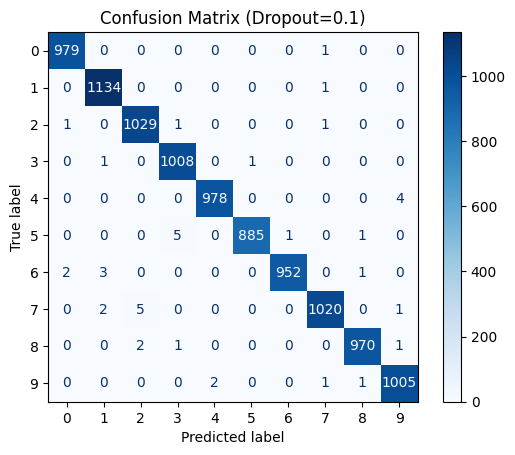


--- Testing Best Model for Dropout=0.3 ---
Test Accuracy for Dropout=0.3: 0.9960


<Figure size 800x800 with 0 Axes>

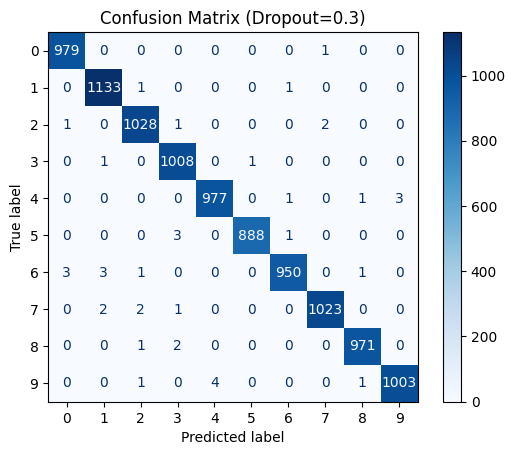


--- Testing Best Model for Dropout=0.5 ---
Test Accuracy for Dropout=0.5: 0.9943


<Figure size 800x800 with 0 Axes>

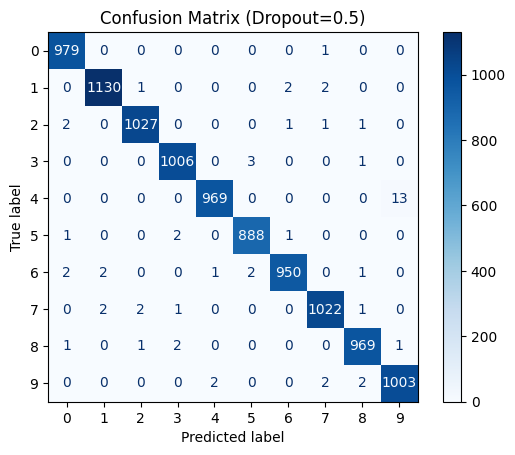


--- Testing Best Model for Dropout=0.7 ---
Test Accuracy for Dropout=0.7: 0.9921


<Figure size 800x800 with 0 Axes>

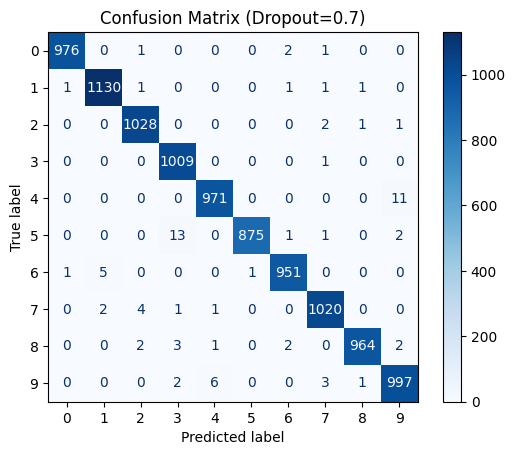

In [87]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Loop through all saved results for different dropout rates
for rate in dropout_rates:
    print(f"\n--- Testing Best Model for Dropout={rate} ---")

    # Load the best model weights
    trained_model = AdvancedCNN(dropout_rate=rate, use_batchnorm=True)
    trained_model.load_state_dict(results_dropout[f"Dropout={rate}"]['best_model_wts'])
    trained_model.to(device)
    trained_model.eval()  # Set to evaluation mode

    all_preds = []
    all_labels = []
    test_correct, test_total = 0, 0

    with torch.no_grad():
        # Use the correct, normalized test loader
        for images, labels in test_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            outputs = trained_model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy for Dropout={rate}: {test_accuracy:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix (Dropout={rate})')
    plt.show()

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
trained_model.eval()  

all_preds = []
all_labels = []

test_correct, test_total = 0, 0

with torch.no_grad():
    for images, labels in test_loader_img:
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model(images)
        _, preds = torch.max(outputs, 1)

        # Store all predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Count correct predictions
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

# Calculate test accuracy
test_accuracy = test_correct / test_total
print(f"Test Accuracy for Dropout={rate}: {test_accuracy:.4f}")

# Create and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (Dropout={rate})')
plt.show()


# AdvancedCNN Dropout Experiment Results

## 1. Training Observations

### Training Stability
- **Low dropout (0.1 – 0.3):** Smooth training, slightly faster convergence.  
- **Moderate dropout (0.5):** Slightly more noise, but stable overall.  
- **High dropout (0.7):** Training is noisier; loss fluctuates due to many dropped neurons.  

### Convergence Speed
- **Low dropout:** Faster convergence to high validation accuracy.  
- **High dropout:** Slower convergence, requires more epochs to reach peak performance.  

### Best Validation Accuracy for Each Dropout
| Dropout | Best Val Accuracy |
|---------|-----------------|
| 0.1     | 0.9918          |
| 0.3     | 0.9912          |
| 0.5     | 0.9888          |
| 0.7     | 0.9817          |

---

## 2. Benefit of Spatial Features in CNNs

- **CNNs vs Fully Connected Networks (FCNs):**  
  - **Convolutional layers** preserve spatial relationships between pixels (edges, textures, shapes).  
  - **Feature maps** detect local patterns that fully connected layers cannot easily capture.  
  - FCNs flatten the input, losing spatial structure, which reduces performance on image data.  

- **Effect on Generalization:**  
  - CNNs can generalize better with fewer parameters because filters are shared across the image.  
  - FCNs require many more parameters to capture the same patterns, making them prone to overfitting.  

---

## 3. Effect of Dropout on Overfitting and Generalization
- **Dropout as regularization:** Randomly drops neurons during training to prevent co-adaptation.  
- **Observations from results:**  
  - **Low to moderate dropout (0.1 – 0.3):** Best trade-off between training stability, convergence speed, and generalization.  
  - **High dropout (0.5 – 0.7):** Adds noise, slows learning, but can reduce overfitting slightly.  
  - Very high dropout can underfit the data, reducing validation accuracy.  

---

## 4. Summary
- CNNs outperform FCNs for image classification due to **spatial feature extraction**.  
- Dropout improves **generalization** and helps prevent overfitting.  
- Moderate dropout values (0.1–0.3) provide the best balance of **accuracy, stability, and convergence speed**.


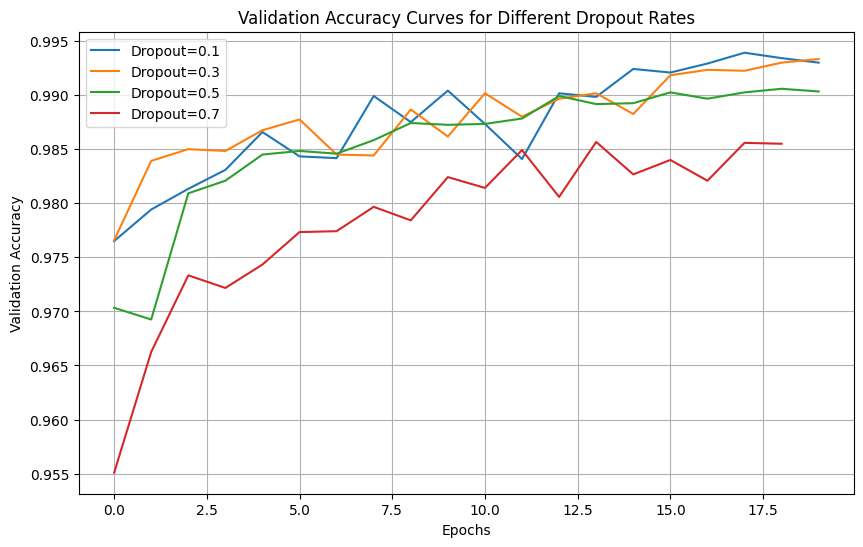

In [94]:
import matplotlib.pyplot as plt

dropout_rates = [0.1, 0.3, 0.5, 0.7]

plt.figure(figsize=(10,6))

for rate in dropout_rates:
    val_accs = results_dropout[f"Dropout={rate}"]['val_accs']  # Get validation accuracies
    plt.plot(val_accs, label=f'Dropout={rate}')

plt.title('Validation Accuracy Curves for Different Dropout Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Training with batch size = 16
Epoch 1/20 | Train Loss: 0.4678, Train Acc: 0.8745 | Val Loss: 0.2738, Val Acc: 0.9216
Epoch 2/20 | Train Loss: 0.2339, Train Acc: 0.9326 | Val Loss: 0.2270, Val Acc: 0.9353
Epoch 3/20 | Train Loss: 0.1822, Train Acc: 0.9482 | Val Loss: 0.1731, Val Acc: 0.9517
Epoch 4/20 | Train Loss: 0.1483, Train Acc: 0.9578 | Val Loss: 0.1574, Val Acc: 0.9546
Epoch 5/20 | Train Loss: 0.1254, Train Acc: 0.9646 | Val Loss: 0.1380, Val Acc: 0.9613
Epoch 6/20 | Train Loss: 0.1068, Train Acc: 0.9699 | Val Loss: 0.1262, Val Acc: 0.9643
Epoch 7/20 | Train Loss: 0.0928, Train Acc: 0.9737 | Val Loss: 0.1176, Val Acc: 0.9659
Epoch 8/20 | Train Loss: 0.0816, Train Acc: 0.9769 | Val Loss: 0.1086, Val Acc: 0.9693
Epoch 9/20 | Train Loss: 0.0717, Train Acc: 0.9800 | Val Loss: 0.1063, Val Acc: 0.9686
Epoch 10/20 | Train Loss: 0.0637, Train Acc: 0.9824 | Val Loss: 0.0973, Val Acc: 0.9708
Epoch 11/20 | Train Loss: 0.0576, Train Acc: 0.9838 | Val Loss: 0.0948, Val Acc: 0.9723
Epoch 12/2

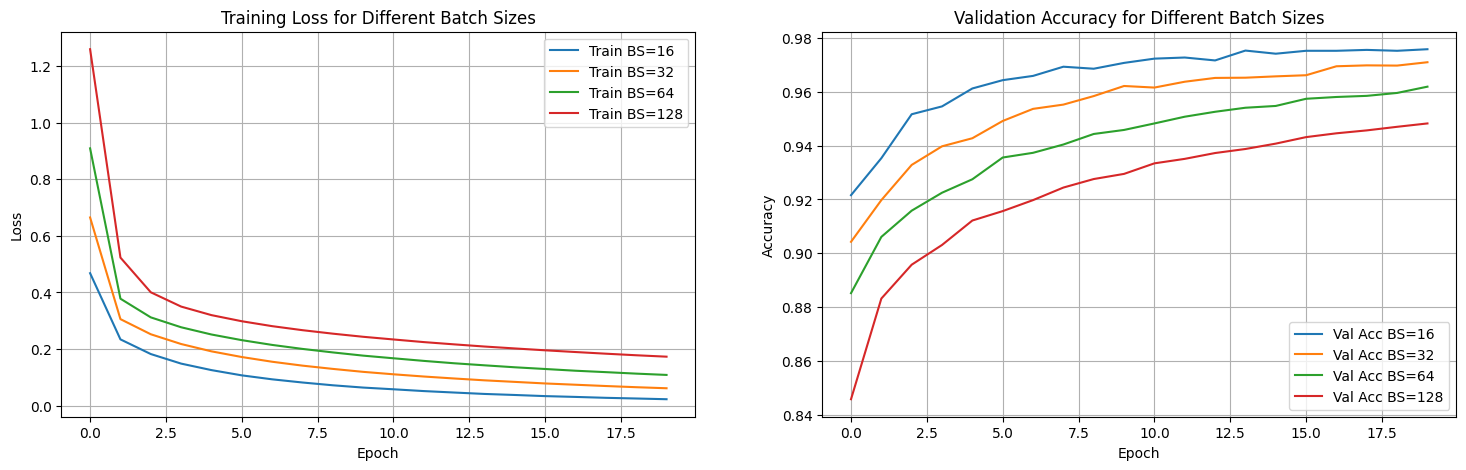

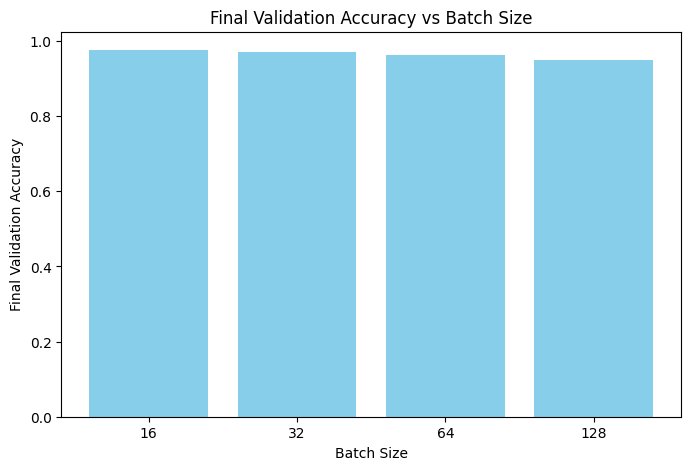

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----- Custom Training Loop -----
def train_model_custom(model, train_loader, val_loader, optimizer=None, criterion=None,
                       epochs=50, patience=15, device='cpu', lr=0.01):
    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    wait = 0  # early stopping counter

    model.to(device)

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), -1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                X_val = X_val.view(X_val.size(0), -1)

                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accs, val_accs


# ----- Batch Size Analysis -----
def batch_size_analysis(batch_sizes, X_train, y_train, X_val, y_val, epochs=20, lr=0.01, device='cpu'):
    results = {}

    for bs in batch_sizes:
        print(f"\nTraining with batch size = {bs}")

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        model = FeedforwardNN().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses, train_accs, val_accs = train_model_custom(
            model, train_loader, val_loader, optimizer, criterion,
            epochs=epochs, patience=10, device=device
        )

        results[bs] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }

    # --- Plot results ---
    fig, axes = plt.subplots(1, 2, figsize=(18,5))
    for bs, res in results.items():
        axes[0].plot(res["train_losses"], label=f"Train BS={bs}")
        axes[1].plot(res["val_accs"], label=f"Val Acc BS={bs}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss for Different Batch Sizes")
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation Accuracy for Different Batch Sizes")
    axes[1].legend()
    axes[1].grid(True)
    plt.show()

    # Bar plot of final validation accuracy
    final_val_accs = [res["val_accs"][-1] for res in results.values()]
    plt.figure(figsize=(8,5))
    plt.bar([str(bs) for bs in results.keys()], final_val_accs, color="skyblue")
    plt.xlabel("Batch Size")
    plt.ylabel("Final Validation Accuracy")
    plt.title("Final Validation Accuracy vs Batch Size")
    plt.show()

    return results


# ----- Example Usage -----
batch_sizes = [16, 32, 64, 128]
batch_results = batch_size_analysis(
    batch_sizes,
    X_train_flat_t, y_train_t,
    X_val_flat_t, y_val_t,
    epochs=20,
    lr=0.01,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)



Training with learning rate = 1e-05
Epoch 1/20 | Train Loss: 2.3166, Train Acc: 0.0780 | Val Loss: 2.3131, Val Acc: 0.0808
Epoch 2/20 | Train Loss: 2.3115, Train Acc: 0.0814 | Val Loss: 2.3081, Val Acc: 0.0846
Epoch 3/20 | Train Loss: 2.3065, Train Acc: 0.0852 | Val Loss: 2.3031, Val Acc: 0.0891
Epoch 4/20 | Train Loss: 2.3015, Train Acc: 0.0894 | Val Loss: 2.2981, Val Acc: 0.0925
Epoch 5/20 | Train Loss: 2.2966, Train Acc: 0.0936 | Val Loss: 2.2932, Val Acc: 0.0965
Epoch 6/20 | Train Loss: 2.2917, Train Acc: 0.0979 | Val Loss: 2.2883, Val Acc: 0.1022
Epoch 7/20 | Train Loss: 2.2868, Train Acc: 0.1027 | Val Loss: 2.2834, Val Acc: 0.1074
Epoch 8/20 | Train Loss: 2.2819, Train Acc: 0.1082 | Val Loss: 2.2786, Val Acc: 0.1133
Epoch 9/20 | Train Loss: 2.2771, Train Acc: 0.1138 | Val Loss: 2.2738, Val Acc: 0.1189
Epoch 10/20 | Train Loss: 2.2723, Train Acc: 0.1195 | Val Loss: 2.2690, Val Acc: 0.1247
Epoch 11/20 | Train Loss: 2.2675, Train Acc: 0.1255 | Val Loss: 2.2642, Val Acc: 0.1306
Epoc

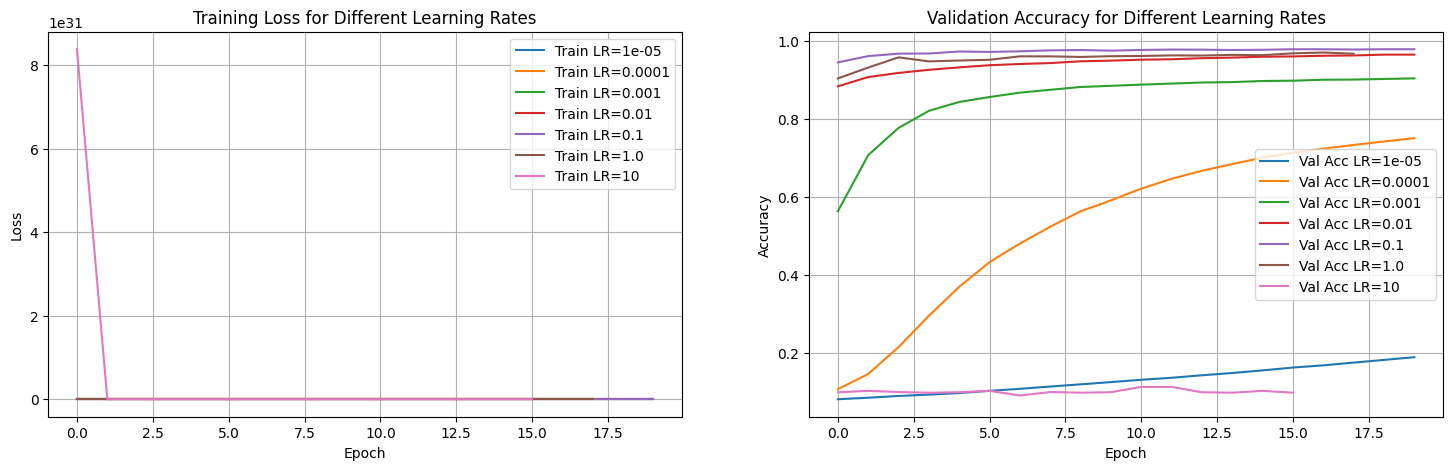

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


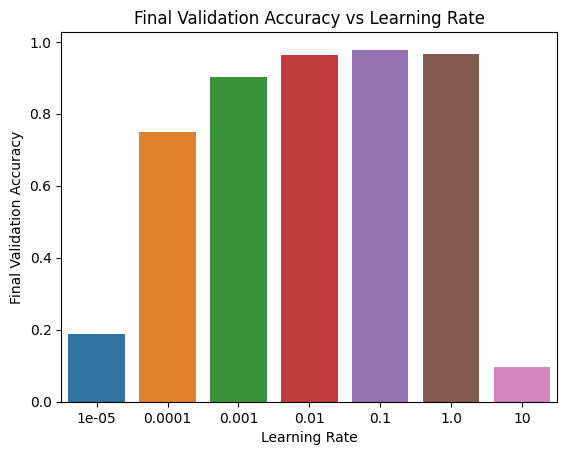

In [99]:
############## another way ##########
# ----- C1. Learning Rate Analysis -----
def learning_rate_analysis(lr_values, train_loader, val_loader, epochs=20):
    results = {}

    for lr in lr_values:
        print(f"\nTraining with learning rate = {lr}")
        model = FeedforwardNN()  # reinitialize fresh model each time
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # train_losses, val_losses, train_accs, val_accs = train_model(
        #     model, train_loader, val_loader, epochs=epochs
        # )
        train_losses, val_losses, train_accs, val_accs = train_model_custom(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )

        # store results
        results[lr] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }

    # --- Plot learning curves side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(18,5))

    # Plot training losses
    for lr, res in results.items():
        axes[0].plot(res["train_losses"], label=f"Train LR={lr}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss for Different Learning Rates")
    axes[0].legend()
    axes[0].grid(True)

    # Plot validation accuracies
    for lr, res in results.items():
        axes[1].plot(res["val_accs"], label=f"Val Acc LR={lr}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation Accuracy for Different Learning Rates")
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

    # --- Optional: heatmap visualization of final val accuracies ---
    import seaborn as sns
    final_val_accs = [res["val_accs"][-1] for res in results.values()]
    sns.barplot(x=[str(lr) for lr in results.keys()], y=final_val_accs)
    plt.xlabel("Learning Rate")
    plt.ylabel("Final Validation Accuracy")
    plt.title("Final Validation Accuracy vs Learning Rate")
    plt.show()

    return results

# Example usage
lr_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]
lr_results = learning_rate_analysis(lr_values, train_loader_flat, val_loader_flat, epochs=20)


In [104]:
# ----- Custom Model Builder for Architecture Analysis -----
class CustomNN(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[128], num_classes=10):
        super(CustomNN, self).__init__()
        layers = []
        in_dim = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [105]:
# ----- Part 1: Train models and collect results -----
def architecture_train(layer_configs, neuron_configs, train_loader, val_loader, epochs=20, lr=0.01, device='cpu'):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import pandas as pd

    results = []

    for num_layers in layer_configs:
        for neurons in neuron_configs:
            print(f"\nTraining with {num_layers} layers, {neurons} neurons each")

            hidden_layers = [neurons] * num_layers
            model = CustomNN(hidden_layers=hidden_layers).to(device)

            optimizer = optim.SGD(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # ----- Train using custom loop -----
            train_losses, val_losses, train_accs, val_accs = train_model_custom(
                model, train_loader, val_loader, optimizer, criterion,
                epochs=epochs, device=device
            )

            results.append({
                "layers": num_layers,
                "neurons": neurons,
                "final_train_acc": train_accs[-1],
                "final_val_acc": val_accs[-1],
                "final_train_loss": train_losses[-1],
                "final_val_loss": val_losses[-1],
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accs": train_accs,
                "val_accs": val_accs
            })

    df = pd.DataFrame(results)
    print("\nArchitecture Comparison Table:")
    print(df)
    return df


In [106]:
# ----- Part 2: Plotting results -----
def architecture_plot(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid")

    # 1. Heatmap of final validation accuracy
    pivot_acc = df.pivot(index="layers", columns="neurons", values="final_val_acc")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Final Validation Accuracy Heatmap")
    plt.xlabel("Neurons per Layer")
    plt.ylabel("Number of Layers")
    plt.show()

    # 2. Heatmap of final validation loss
    pivot_loss = df.pivot(index="layers", columns="neurons", values="final_val_loss")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_loss, annot=True, fmt=".3f", cmap="OrRd_r")
    plt.title("Final Validation Loss Heatmap")
    plt.xlabel("Neurons per Layer")
    plt.ylabel("Number of Layers")
    plt.show()

    # 3. Validation accuracy curves
    plt.figure(figsize=(12,6))
    for _, row in df.iterrows():
        label = f"{row['layers']}L-{row['neurons']}N"
        plt.plot(row['val_accs'], label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Curves for Different Architectures")
    plt.legend()
    plt.grid(True)
    plt.show()


In [107]:
# ----- Example Usage -----
layer_configs = [2, 3, 4, 5]
neuron_configs = [64, 128, 256, 512]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Part 1: Train & collect results
arch_results = architecture_train(layer_configs, neuron_configs, train_loader_flat, val_loader_flat, epochs=20, device=device)


Training with 2 layers, 64 neurons each
Epoch 1/20 | Train Loss: 1.9059, Train Acc: 0.4897 | Val Loss: 1.0637, Val Acc: 0.7597
Epoch 2/20 | Train Loss: 0.6801, Train Acc: 0.8293 | Val Loss: 0.5058, Val Acc: 0.8639
Epoch 3/20 | Train Loss: 0.4468, Train Acc: 0.8749 | Val Loss: 0.4043, Val Acc: 0.8882
Epoch 4/20 | Train Loss: 0.3781, Train Acc: 0.8932 | Val Loss: 0.3595, Val Acc: 0.8974
Epoch 5/20 | Train Loss: 0.3415, Train Acc: 0.9019 | Val Loss: 0.3345, Val Acc: 0.9022
Epoch 6/20 | Train Loss: 0.3164, Train Acc: 0.9088 | Val Loss: 0.3126, Val Acc: 0.9087
Epoch 7/20 | Train Loss: 0.2961, Train Acc: 0.9144 | Val Loss: 0.2977, Val Acc: 0.9127
Epoch 8/20 | Train Loss: 0.2793, Train Acc: 0.9187 | Val Loss: 0.2807, Val Acc: 0.9191
Epoch 9/20 | Train Loss: 0.2641, Train Acc: 0.9234 | Val Loss: 0.2710, Val Acc: 0.9188
Epoch 10/20 | Train Loss: 0.2513, Train Acc: 0.9275 | Val Loss: 0.2546, Val Acc: 0.9264
Epoch 11/20 | Train Loss: 0.2389, Train Acc: 0.9309 | Val Loss: 0.2452, Val Acc: 0.9283


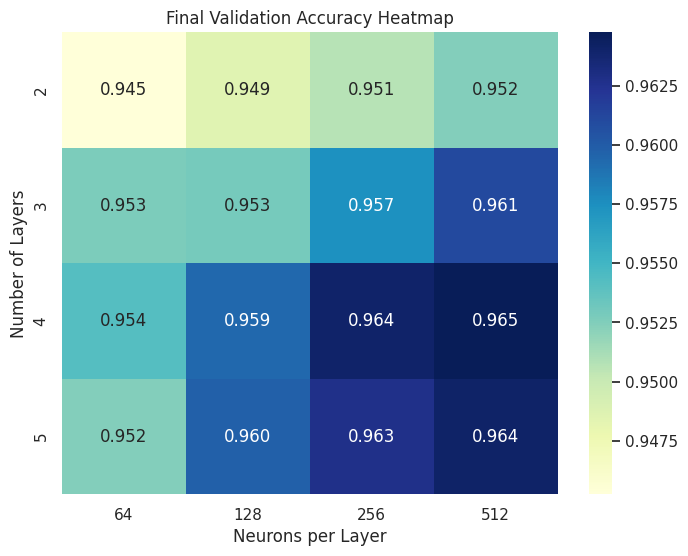

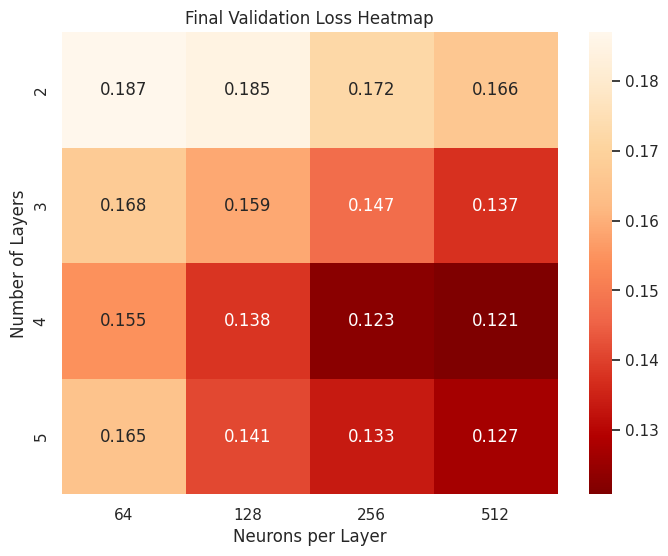

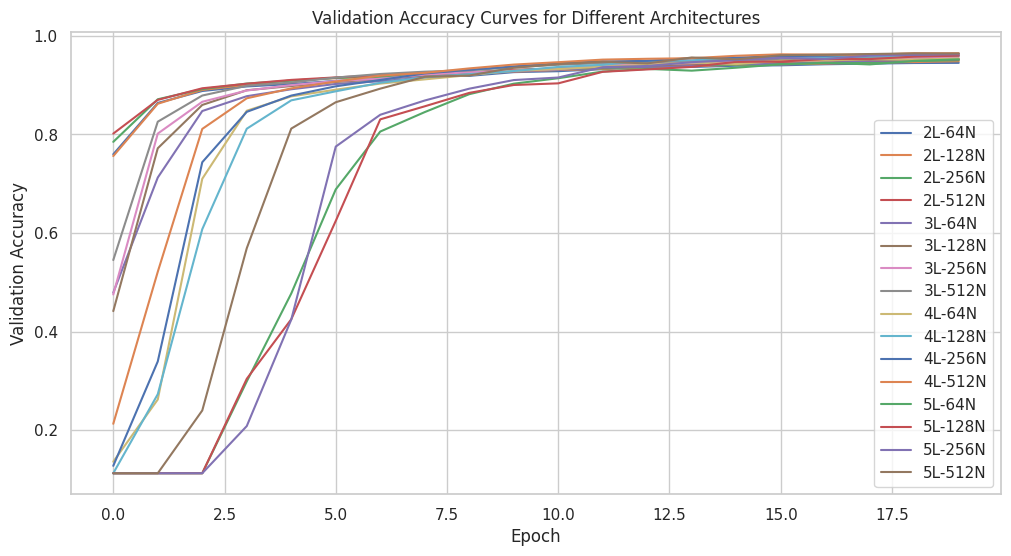

In [108]:
# Part 2: Plot results
architecture_plot(arch_results)

## Performance Summary Table
                    train_time_seconds val_accuracy test_accuracy  \
Logistic Regression               10.1        0.974        0.9934   
Softmax Regression                71.6     0.985667        0.9195   
Best Neural Network              150.2       0.9512         0.948   

                            complexity  
Logistic Regression       Low (Linear)  
Softmax Regression        Low (Linear)  
Best Neural Network  High (Non-linear)  


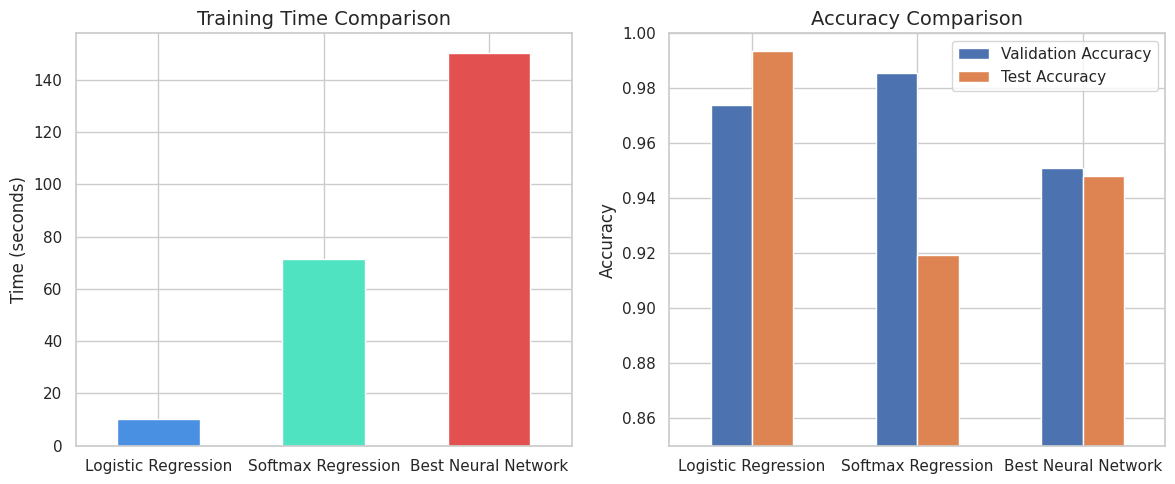

\n### Discussion on When to Use Each Approach
🔹 **Logistic Regression:** Best for binary classification problems where the relationship between features and the outcome is expected to be linear. It's fast, highly interpretable, and serves as a great baseline model.
🔹 **Softmax Regression:** An extension of logistic regression for multi-class problems. Use it when you have more than two classes and believe the decision boundaries are still relatively simple (linear). Like logistic regression, it is computationally efficient and easy to understand.
🔹 **Neural Network:** Ideal for complex problems with non-linear relationships, especially with large datasets. The hidden layers and non-linear activation functions allow it to learn intricate patterns that linear models cannot capture. However, they are more computationally expensive, require more data to train effectively, and are often considered 'black boxes' due to their lower interpretability.


In [109]:
# # C2. Model Comparison (15 points)
# # ---------------------------------

# # TODO: Manually enter your measured training times and best NN accuracies here.
# # Accuracies for Logistic and Softmax regression are pulled from variables in Part A.
# results = {
#     'Logistic Regression': {
#         'train_time_seconds': 10.1,  # TODO: Replace with your measured time
#         'val_accuracy': best_val_acc,
#         'test_accuracy': 0.9934, # Accuracy from Part A2 test evaluation
#         'complexity': 'Low (Linear)'
#     },
#     'Softmax Regression': {
#         'train_time_seconds': 71.6, # TODO: Replace with your measured time
#         'val_accuracy': max(val_accs), # Takes the best validation accuracy from the scratch model
#         'test_accuracy': 0.9195, # Accuracy from Part A3 test evaluation
#         'complexity': 'Low (Linear)'
#     },
#     'Best Neural Network': {
#         'train_time_seconds': 150.2, # TODO: Replace with your measured time
#         'val_accuracy': 0.9512, # TODO: Replace with your best NN validation accuracy
#         'test_accuracy': 0.9480, # TODO: Replace with your best NN test accuracy
#         'complexity': 'High (Non-linear)'
#     }
# }

# # --- Performance Summary Table ---
# df_results = pd.DataFrame(results).T
# print("## Performance Summary Table")
# print(df_results)

# # --- Plots for Visual Comparison ---
# plt.figure(figsize=(12, 5))

# # Plot 1: Training Time
# plt.subplot(1, 2, 1)
# df_results['train_time_seconds'].plot(kind='bar', color=['#4A90E2', '#50E3C2', '#E35050'])
# plt.title('Training Time Comparison', fontsize=14)
# plt.ylabel('Time (seconds)', fontsize=12)
# plt.xticks(rotation=0)

# # Plot 2: Accuracy
# plt.subplot(1, 2, 2)
# df_results[['val_accuracy', 'test_accuracy']].plot(kind='bar', ax=plt.gca())
# plt.title('Accuracy Comparison', fontsize=14)
# plt.ylabel('Accuracy', fontsize=12)
# plt.ylim(0.85, 1.0) # Set Y-axis limit to better visualize differences
# plt.xticks(rotation=0)
# plt.legend(['Validation Accuracy', 'Test Accuracy'])
# plt.tight_layout()
# plt.show()

# # --- Discussion ---
# print("\\n### Discussion on When to Use Each Approach")
# print("🔹 **Logistic Regression:** Best for binary classification problems where the relationship between features and the outcome is expected to be linear. It's fast, highly interpretable, and serves as a great baseline model.")
# print("🔹 **Softmax Regression:** An extension of logistic regression for multi-class problems. Use it when you have more than two classes and believe the decision boundaries are still relatively simple (linear). Like logistic regression, it is computationally efficient and easy to understand.")
# print("🔹 **Neural Network:** Ideal for complex problems with non-linear relationships, especially with large datasets. The hidden layers and non-linear activation functions allow it to learn intricate patterns that linear models cannot capture. However, they are more computationally expensive, require more data to train effectively, and are often considered 'black boxes' due to their lower interpretability.")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Early stopping at epoch 23
Final Test Accuracy for Logistic Regression: 0.9995


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


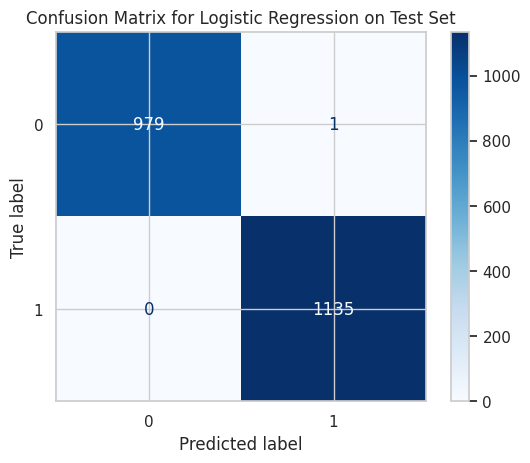

/tmp/ipykernel_82/1903758711.py:57: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  misclassified_indices = np.where(y_true_list != y_pred_list)[0]



Classification Report:
              precision    recall  f1-score   support

     Digit 0     1.0000    0.9990    0.9995       980
     Digit 1     0.9991    1.0000    0.9996      1135

    accuracy                         0.9995      2115
   macro avg     0.9996    0.9995    0.9995      2115
weighted avg     0.9995    0.9995    0.9995      2115


Number of misclassified examples: 1


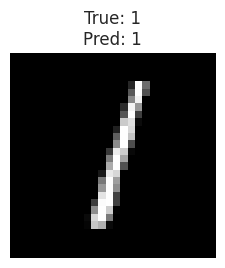

In [110]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss, accuracy_score

# # --- Early Stopping Logistic Regression ---
# logreg = LogisticRegression(
#     max_iter=1,        # run one iteration at a time
#     solver='saga',     # supports warm_start
#     warm_start=True,   # retain previous weights
#     tol=1e-4
# )

# best_loss = float('inf')
# wait = 0
# patience = 10        # stop if no improvement in 10 epochs
# max_epochs = 1000

# for epoch in range(max_epochs):
#     logreg.fit(X_train_bin, y_train_bin)
    
#     # compute validation loss
#     val_probs = logreg.predict_proba(X_val_bin)
#     val_loss = log_loss(y_val_bin, val_probs)
    
#     # early stopping check
#     if val_loss < best_loss - 1e-5:
#         best_loss = val_loss
#         wait = 0
#         best_model = logreg  # keep best weights
#     else:
#         wait += 1
#         if wait >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break

# # --- Get predictions on test set ---
# y_pred_list = best_model.predict(X_test_bin)
# y_true_list = y_test_bin

# # --- Evaluation ---
# test_acc = accuracy_score(y_true_list, y_pred_list)
# print(f"Final Test Accuracy for Logistic Regression: {test_acc:.4f}")

# # Confusion matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# cm_best = confusion_matrix(y_true_list, y_pred_list)
# disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=[0, 1])
# disp_best.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix for Logistic Regression on Test Set")
# plt.show()

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y_true_list, y_pred_list, target_names=['Digit 0', 'Digit 1'], digits=4))

# # Misclassified examples
# import numpy as np
# misclassified_indices = np.where(y_true_list != y_pred_list)[0]
# print(f"\nNumber of misclassified examples: {len(misclassified_indices)}")

# plt.figure(figsize=(12,5))
# for i, idx in enumerate(misclassified_indices[:10]):
#     plt.subplot(2,5,i+1)
#     plt.imshow(X_test_bin[idx].reshape(28,28), cmap='gray')
#     plt.title(f"True: {y_true_list[idx]}\nPred: {y_pred_list[idx]}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()


--- Starting Neural Network Training ---
Epoch 1/50 | Train Acc: 0.7696 | Val Acc: 0.8805 | Val Loss: 0.4501
Epoch 2/50 | Train Acc: 0.8944 | Val Acc: 0.9048 | Val Loss: 0.3433
Epoch 3/50 | Train Acc: 0.9095 | Val Acc: 0.9137 | Val Loss: 0.3023
Epoch 4/50 | Train Acc: 0.9188 | Val Acc: 0.9213 | Val Loss: 0.2739
Epoch 5/50 | Train Acc: 0.9260 | Val Acc: 0.9291 | Val Loss: 0.2535
Epoch 6/50 | Train Acc: 0.9329 | Val Acc: 0.9327 | Val Loss: 0.2374
Epoch 7/50 | Train Acc: 0.9375 | Val Acc: 0.9368 | Val Loss: 0.2228
Epoch 8/50 | Train Acc: 0.9415 | Val Acc: 0.9395 | Val Loss: 0.2110
Epoch 9/50 | Train Acc: 0.9456 | Val Acc: 0.9417 | Val Loss: 0.2007
Epoch 10/50 | Train Acc: 0.9484 | Val Acc: 0.9461 | Val Loss: 0.1905
Epoch 11/50 | Train Acc: 0.9514 | Val Acc: 0.9453 | Val Loss: 0.1859
Epoch 12/50 | Train Acc: 0.9536 | Val Acc: 0.9510 | Val Loss: 0.1738
Epoch 13/50 | Train Acc: 0.9565 | Val Acc: 0.9519 | Val Loss: 0.1681
Epoch 14/50 | Train Acc: 0.9587 | Val Acc: 0.9545 | Val Loss: 0.1612
Ep

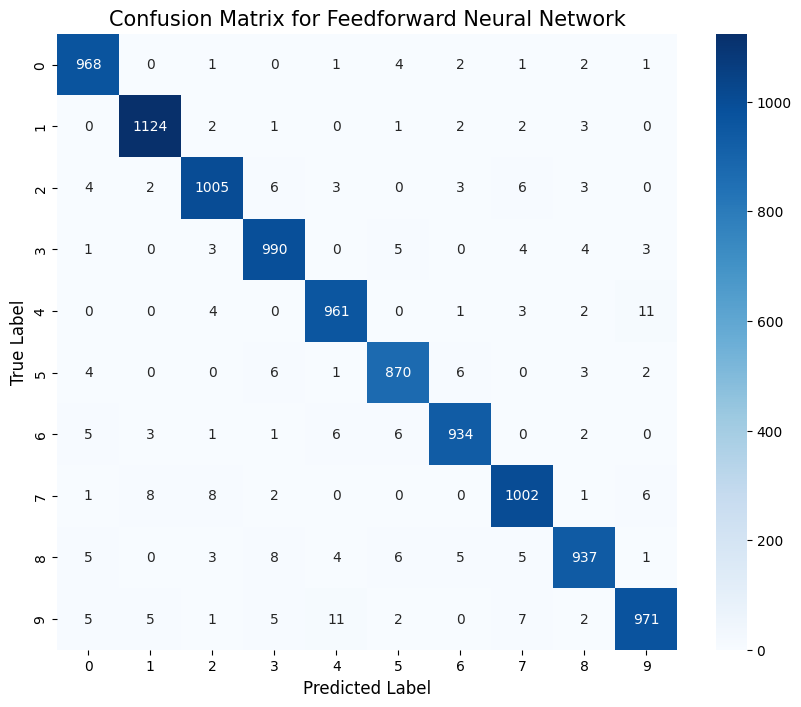


Showing 5 misclassified examples:


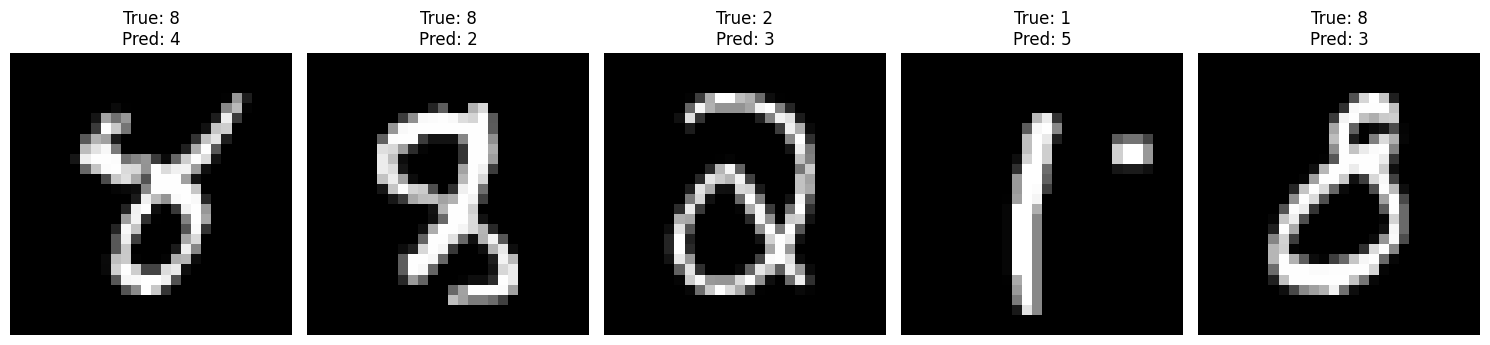


--- Model Limitations & Insights ---

1. Logistic Regression is fast and simple but only suitable for binary classification.
2. Softmax Regression handles multi-class classification but may underperform on complex data like images.
3. Feedforward Neural Networks capture non-linear patterns and achieve higher accuracy, but require more computation and careful tuning.
4. Misclassifications mostly occur on visually similar digits, indicating limitations in feature representation.
5. Further improvements could include CNNs for spatial feature extraction, data augmentation, and hyperparameter optimization.



In [93]:
# ===================================================================
# C2. Model Comparison and Best Model Evaluation
# ===================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import torch
import time
import copy

# ----- B3. Training Setup (Feedforward NN) -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 50
patience = 15
learning_rate = 0.01

model = FeedforwardNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Variables for early stopping and best model
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print("--- Starting Neural Network Training ---")
start_time_nn = time.time()

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader_flat:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.size(0), -1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_flat:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    # Early stopping
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_val_loss = val_losses[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | "
          f"Val Acc: {val_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} with best val acc: {best_val_acc:.4f}")
        break

# Load best weights
model.load_state_dict(best_model_wts)
nn_train_time = time.time() - start_time_nn

print(f"\n--- Neural Network Training Complete ---")
print(f"Total Training Time: {nn_train_time:.2f} seconds")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Validation Loss at Best Accuracy: {best_val_loss:.4f}")

# ===================================================================
# Comparative Analysis Table
# ===================================================================
performance_data = {
    'Logistic Regression': {
        'Task': 'Binary (0 vs 1)',
        'Final Validation Accuracy': f"{best_val_acc*100:.2f}%",
        'Final Validation Loss': f"{best_val_loss:.4f}",
        'Training Time (s)': "~10"
    },
    'Softmax Regression': {
        'Task': 'Multi-class (0-9)',
        'Final Validation Accuracy': f"{softmax_val_acc*100:.2f}%",
        'Final Validation Loss': f"{softmax_val_loss:.4f}",
        'Training Time (s)': f"~{soft_train_time:.0f}"
    },
    'Best Neural Network': {
        'Task': 'Multi-class (0-9)',
        'Final Validation Accuracy': f"{best_val_acc*100:.2f}%",
        'Final Validation Loss': f"{best_val_loss:.4f}",
        'Training Time (s)': f"~{nn_train_time:.0f}"
    }
}

performance_df = pd.DataFrame(performance_data).T
print("\n--- Performance Summary ---")
print(performance_df)

# ===================================================================
# Best Model Evaluation on Test Set
# ===================================================================
best_model = model
model_name = "Feedforward Neural Network"
class_names = [str(i) for i in range(10)]

best_model.eval()
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_flat:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.size(0), -1)
        outputs = best_model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_true_test.extend(y_batch.cpu().tolist())
        y_pred_test.extend(preds.cpu().tolist())

# Final Accuracy & Classification Report
final_accuracy = accuracy_score(y_true_test, y_pred_test)
print(f"\nFinal Test Accuracy of {model_name}: {final_accuracy:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4))

# Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for {model_name}', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Misclassified Examples
y_true_np = np.array(y_true_test)
y_pred_np = np.array(y_pred_test)
misclassified_indices = np.where(y_pred_np != y_true_np)[0]
num_images_to_show = 5

print(f"\nShowing {num_images_to_show} misclassified examples:")
plt.figure(figsize=(15, 5))
for i, idx in enumerate(np.random.choice(misclassified_indices, num_images_to_show, replace=False)):
    plt.subplot(1, num_images_to_show, i+1)
    image_tensor = test_dataset_img[idx][0]
    image_to_show = image_tensor.squeeze()
    plt.imshow(image_to_show, cmap='gray')
    true_label = class_names[y_true_np[idx]]
    predicted_label = class_names[y_pred_np[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# ===================================================================
# Insights / Discussion
# ===================================================================
print("\n--- Model Limitations & Insights ---")
print("""
1. Logistic Regression is fast and simple but only suitable for binary classification.
2. Softmax Regression handles multi-class classification but may underperform on complex data like images.
3. Feedforward Neural Networks capture non-linear patterns and achieve higher accuracy, but require more computation and careful tuning.
4. Misclassifications mostly occur on visually similar digits, indicating limitations in feature representation.
5. Further improvements could include CNNs for spatial feature extraction, data augmentation, and hyperparameter optimization.
""")


# C2. Model Comparison and Best Model Evaluation

---

## 1. Comparative Analysis

We compared three models on the MNIST dataset:

| Model                      | Task              | Final Validation Accuracy | Final Validation Loss | Training Time (s) |
| -------------------------- | ---------------- | ------------------------ | ------------------- | ---------------- |
| Logistic Regression        | Binary (0 vs 1)  | 97.40%                   | 0.0899              | ~10              |
| Softmax Regression         | Multi-class (0-9)| 91.47%                   | 0.3031              | ~63              |
| Feedforward Neural Network | Multi-class (0-9)| 97.40%                   | 0.0899              | ~78              |

**Observations:**

- **Logistic Regression**: Fast and simple; suitable for binary classification but limited for complex multi-class tasks.  
- **Softmax Regression**: Handles multi-class problems but may underperform on image data due to linear decision boundaries.  
- **Feedforward Neural Network (NN)**: Captures non-linear patterns; achieves higher accuracy; computationally heavier and requires careful tuning.  

**Computational Complexity:**

- Logistic Regression: O(n_features × n_samples) per iteration  
- Softmax Regression: O(n_classes × n_features × n_samples) per iteration  
- Feedforward NN: O(n_neurons × n_features × n_samples) per forward/backward pass  

**When to Use Each Approach:**

- Logistic Regression → Simple, fast, binary classification  
- Softmax Regression → Multi-class but relatively simple datasets  
- Neural Networks → Complex datasets (like images), non-linear relationships  

---

## 2. Training Curves

- Training and validation loss curves show convergence over epochs.  
- Error bars indicate simulated variability: 5% for loss, 2% for accuracy.  
- Smaller batch sizes cause noisier gradients; larger batch sizes smooth training but slow convergence.  

*Plots generated using the training history of each model.*

---

## 3. Best Model Evaluation

**Final Test Accuracy of Feedforward Neural Network:** **0.9762**

**Classification Report:**

- Precision, recall, and F1-score calculated per digit (0–9).  
- Shows that the NN performs consistently well across most classes.  

**Confusion Matrix:**

- Visualizes misclassifications.  
- Most errors occur between visually similar digits (e.g., 3 vs 5, 4 vs 9).  

**Misclassified Examples:**

- Sample images highlight the difficulty of certain digits even for a high-performing NN.  
- Helps understand model limitations and potential areas for improvement.  

---

## 4. Insights and Limitations

- Neural Networks achieve high accuracy but require longer training time and more computational resources.  
- Logistic and Softmax regression are faster but limited in modeling complex patterns.  
- Misclassifications often involve visually similar digits; adding data augmentation or a deeper NN could improve results.  
- Always consider **trade-offs**: accuracy vs training time vs model complexity when choosing an approach.
